In [1]:
import re
import sys
import math
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn import linear_model, decomposition, datasets
from __future__ import print_function
from collections import defaultdict
from sklearn.multiclass import OneVsRestClassifier
import itertools
import catboost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

CONSTRUCTONS = [ 'F9','GP1BB','HBB','HBG1','HNF4A_P2','IRF4','IRF6','LDLR','MSMB',
                 'MYC_rs6983267','PKLR','SORT1','TERT_GBM','TERT_HEK293T','ZFAND3']


# BASELINE_FEATURE_LIST = ['dnaseScore.cons.bymax', 'phyloP100way', 'CAGE.count.bymax_log']
# BASELINE_FEATURE_LIST = [
#     'CAGE.count.bymax_log', 'CAGE.dist2max_log',
#     'phyloP100way', 'phastCons100way',
#     'mz100_log_diff',
#     'dnaseScore.cons.max.bymax', 'dnaseScore.cons.bymax', 'dnaseScore.cons.pval.max.bymax'
# ]
BASELINE_FEATURE_LIST = [
    'CAGE.count.bymax_log',
    'phyloP100way', 'phastCons100way', 'mz100_log_diff',
    'dnaseScore.cons.byq3', 'atacSeq.cons.byq3', 'dnaseScore.cons.max.byq3', 'atacSeq.cons.max.byq3',
]
    
def split_features_and_target(full_data):
    data = full_data.copy()
    del data['SNV']
    if 'block_num' in data:
        del data['block_num']
    del data['value']
    del data['construction']
    
    if 'confidence_scaled' in data.keys():
        del data['confidence_scaled']
    if 'confidence_renormed_irf4' in data.keys():
        del data['confidence_renormed_irf4']
    confidence = data['confidence']
        
    #answers = 0 + (confidence > 0.1)
    answers = confidence
    del data['confidence']
    return (data, answers)

def split_by_construction(data, construction):
    test_data = data[data.construction == construction]
    
    if construction.startswith('TERT'):
        train_data = data[(data.construction != 'TERT_GBM') & (data.construction != 'TERT_HEK293T')]
    else:
        train_data = data[data.construction != construction]
    return (train_data, test_data)

# def get_construction(data, constructions):
#     results = []
#     for construction in constructions:
#         results.append(data[data.construction == construction])
#     return pd.concat(results)

def split_by_block(data, block_num):
    test_data = data[data.block_num == block_num]
    train_data = data[data.block_num != block_num]
    return (train_data, test_data)

def filter_features(data, condition):
    features = data.keys()
    take_always_features = ['SNV','construction',
                            'value', 'confidence',
                            #'confidence_scaled', 'confidence_renormed_irf4'
                           ]
    if 'block_num' in features:
        take_always_features.append('block_num')
    features = list(filter(lambda feature: feature not in take_always_features, features))
    features_to_add = list(filter(condition, features))
    columns = take_always_features + list(np.unique(features_to_add))
    return data[columns]

def filter_features_by_type(data, feature_types):
    if feature_types == 'all':
        return data
    else:
        return filter_features(data, lambda feature: feature.rsplit(':')[-1] in feature_types)

def get_rocs(class_labels_and_score_pairs, label = 'ROC', filename=None, plot=True):
    COLORS = ['darkorange', 'red', 'green', 'blue', 'cyan', 'magenta']
    results = {}
    lw = 2
    if plot:
        plt.figure()
    for idx,(class_labels, scores, dataset_label) in enumerate(class_labels_and_score_pairs):
        fpr, tpr, _ = sklearn.metrics.roc_curve(class_labels, scores)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        results[dataset_label] = roc_auc
        if plot:
            plt.plot(fpr, tpr, color=COLORS[idx], lw=lw, 
                     label=dataset_label + ' ROC curve (area = %0.2f)' % roc_auc)
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(label)
        plt.legend(loc="lower right")
        plt.show()
        if filename:
            plt.savefig(filename)
    return results


def get_baseline_prediction(data_train_full, data_test_full):
    baseline_feature_list = BASELINE_FEATURE_LIST
    train_data = filter_features(data_train_full, lambda f: f in baseline_feature_list)
    test_data = filter_features(data_test_full, lambda f: f in baseline_feature_list)
#     print(train_data.keys())
#     print(test_data.keys())
    
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)

    classifier = GridSearchCV(xgb.XGBRegressor(), 
                              param_grid={'n_estimators': range(1,51,5), 'max_depth': range(1,4)},
#                               param_grid={'n_estimators': [100], 'max_depth': [3]},
                              cv=10, refit=True, scoring='neg_mean_absolute_error')
#     classifier = GridSearchCV(sklearn.svm.LinearSVR(), 
#                               param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
#                                           'C': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]},
#                               cv=10, refit=True, scoring='neg_mean_absolute_error')
    classifier.fit(X_train, y_train)
    print(classifier.best_params_)
    predictions_train = classifier.predict(X_train)
    predictions_test = classifier.predict(X_test)
    
    class_labels_test = [1 if y > 0.1 else 0 for y in y_test]
    class_labels_train = [1 if y > 0.1 else 0 for y in y_train]
    
    roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, predictions_test)
    roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, predictions_train)
    mean_ap = sklearn.metrics.average_precision_score(class_labels_test, predictions_test)
    mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, predictions_train)
    print(roc_auc, mean_ap, roc_auc_train, mean_ap_train)

    return (predictions_train, predictions_test)

def get_baseline_prediction_classifier(data_train_full, data_test_full):
    baseline_feature_list = BASELINE_FEATURE_LIST
    baseline_feature_list = [
        'CAGE.count.bymax_log',
        'phyloP100way', 'phastCons100way', 'mz100_log_diff',
        'dnaseScore.cons.byq3', 'atacSeq.cons.byq3', 'dnaseScore.cons.max.byq3', 'atacSeq.cons.max.byq3',
    ]
    train_data = filter_features(data_train_full, lambda f: f in baseline_feature_list)
    test_data = filter_features(data_test_full, lambda f: f in baseline_feature_list)
#     print(train_data.keys())
#     print(test_data.keys())

    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)

    class_labels_test = [1 if y > 0.1 else 0 for y in y_test]
    class_labels_train = [1 if y > 0.1 else 0 for y in y_train]
    
    classifier = GridSearchCV(xgb.XGBClassifier(), 
#                               param_grid={'n_estimators': [100], 'max_depth': [3]},
                              param_grid={'n_estimators': range(1,101,5), 'max_depth': range(1,4)},
                              cv=10, refit=True, scoring='average_precision')
#     classifier = GridSearchCV(sklearn.svm.LinearSVR(), 
#                               param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
#                                           'C': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]},
#                               cv=10, refit=True, scoring='neg_mean_absolute_error')
    classifier.fit(X_train, class_labels_train)
    print(classifier.best_params_)
    predictions_train = classifier.predict_proba(X_train)[:,1]
    predictions_test = classifier.predict_proba(X_test)[:,1]
    
    roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, predictions_test)
    roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, predictions_train)
    mean_ap = sklearn.metrics.average_precision_score(class_labels_test, predictions_test)
    mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, predictions_train)
    print(roc_auc, mean_ap, roc_auc_train, mean_ap_train)

    return (predictions_train, predictions_test)

def get_baseline_prediction_multiple(data_train_full, multiple_data_test_full):
    baseline_feature_list = BASELINE_FEATURE_LIST
    train_data = filter_features(data_train_full, lambda f: f in baseline_feature_list)
#     print(train_data.keys())
    
    X_train, y_train = split_features_and_target(train_data)

    classifier = GridSearchCV(xgb.XGBRegressor(), 
                              param_grid={'n_estimators': range(1,51,5), 'max_depth': range(1,4)},
                              cv=10, refit=True, scoring='neg_mean_absolute_error')
    classifier.fit(X_train, y_train)
    print(classifier.best_params_)
    predictions_train = classifier.predict(X_train)
    multiple_predictions_test = []
    for data_test_full in multiple_data_test_full:
        test_data = filter_features(data_test_full, lambda f: f in baseline_feature_list)
        X_test, y_test = split_features_and_target(test_data)
        predictions_test = classifier.predict(X_test)
        multiple_predictions_test.append(predictions_test)

    return (predictions_train, multiple_predictions_test)

def get_baseline_prediction_classifier_multiple(data_train_full, multiple_data_test_full):
    baseline_feature_list = BASELINE_FEATURE_LIST
    train_data = filter_features(data_train_full, lambda f: f in baseline_feature_list)
#     print(train_data.keys())

    X_train, y_train = split_features_and_target(train_data)

    class_labels_train = [1 if y > 0.1 else 0 for y in y_train]
    
    classifier = GridSearchCV(xgb.XGBClassifier(), 
                              param_grid={'n_estimators': range(1,101,5), 'max_depth': range(1,4)},
                              cv=10, refit=True, scoring='average_precision')
    classifier.fit(X_train, class_labels_train)
    print(classifier.best_params_)
    predictions_train = classifier.predict_proba(X_train)[:,1]

    multiple_predictions_test = []
    for data_test_full in multiple_data_test_full:
        test_data = filter_features(data_test_full, lambda f: f in baseline_feature_list)
        X_test, y_test = split_features_and_target(test_data)
        predictions_test = classifier.predict_proba(X_test)[:,1]
        multiple_predictions_test.append(predictions_test)
        
    return (predictions_train, multiple_predictions_test)


def flatten(listOfLists):
    return list(itertools.chain.from_iterable(listOfLists))


In [2]:
DATA_TRAIN = pd.read_csv('features/motif_unnormed_expression_families_conservativity_cage_dnase_blocks.tsv', sep='\t')
DATA_VAL = pd.read_csv('features/validation_motif_unnormed_expression_families_conservativity_cage_dnase.tsv', sep='\t')
DATA_TEST = pd.read_csv('features/motif_unnormed_features_trivariate_with_cons_cage_dnase.tsv', sep='\t')

BASELINE_PREDICTION_TRAIN, (BASELINE_PREDICTION_TEST, BASELINE_PREDICTION_VAL) = get_baseline_prediction_multiple(DATA_TRAIN, [DATA_TEST, DATA_VAL])
BASELINE_CLASSIFICATION_PREDICTION_TRAIN, (BASELINE_CLASSIFICATION_PREDICTION_TEST, BASELINE_CLASSIFICATION_PREDICTION_VAL) = get_baseline_prediction_classifier_multiple(DATA_TRAIN, [DATA_TEST, DATA_VAL])

{'n_estimators': 46, 'max_depth': 2}
{'n_estimators': 31, 'max_depth': 1}


In [3]:
sklearn.warnings.simplefilter('ignore', DeprecationWarning)

stat = lambda xs: (np.mean(xs), np.std(xs))

def train_classifier(test_data, train_data, test_baseline, train_baseline):
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)
    
    X_train['baseline'] = train_baseline
    X_test['baseline'] = test_baseline
    
    y_train = 0 + (y_train > 0.1)
    y_test = 0 + (y_test > 0.1)
    
#     classifier = GridSearchCV(xgb.XGBClassifier(), 
#                               param_grid={'n_estimators': range(1,101,10), 'max_depth': range(1,4)},
#                               cv=10, refit=True, scoring='average_precision')
#     classifier = GridSearchCV(sklearn.svm.LinearSVC(),
#                               param_grid={'C': [0.05, 0.1, 0.2, 0.5, 1]},
#                               cv=10, refit=True, scoring='average_precision')
#     classifier = GridSearchCV(sklearn.linear_model.LogisticRegression(),
#                               param_grid={'penalty': ['l1', 'l2'], 'C': [0.05, 0.1, 0.2, 0.5, 1,]},
#                               cv=10, refit=True, scoring='average_precision')
    classifier = sklearn.linear_model.LogisticRegression()
    
    cv_stats = sklearn.model_selection.cross_validate(classifier, X_train, y_train, return_train_score=True, cv=10)
#     print('trained', stat(cv_stats['train_score']), stat(cv_stats['test_score']))
    classifier.fit(X_train, y_train)
#     print(classifier.best_params_)
    
    predictions_train = classifier.predict_proba(X_train)[:,1]
    predictions_test = classifier.predict_proba(X_test)[:,1]
#     predictions_train = classifier.decision_function(X_train)
#     predictions_test = classifier.decision_function(X_test)
    return {
        'y_test': y_test,
        'y_train': y_train,
        'predictions_test': predictions_test,
        'predictions_train': predictions_train,
    }

def train_and_test_classifier(test_data, train_data, test_baseline, train_baseline):
    infos = train_classifier(test_data, train_data, test_baseline, train_baseline)
#     y_test, y_train = infos['y_test'], infos['y_train']
    predictions_test, predictions_train = infos['predictions_test'], infos['predictions_train']
        
#     class_labels_test = y_test
#     class_labels_train = y_train
    
#     roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, predictions_test)
#     roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, predictions_train)
    
#     mean_ap = sklearn.metrics.average_precision_score(class_labels_test, predictions_test)
#     mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, predictions_train)
    
# #     mse = sklearn.metrics.mean_squared_error(y_test, predictions_test)
# #     mse_train = sklearn.metrics.mean_squared_error(y_train, predictions_train)

#     base_clf_pred_train_df = pd.DataFrame({'baseline': train_baseline})
#     baseline_cv_stats = sklearn.model_selection.cross_validate(sklearn.linear_model.LogisticRegression(), base_clf_pred_train_df, y_train, return_train_score=True, cv=10)
# #     print('baseline', stat(baseline_cv_stats['train_score']), stat(baseline_cv_stats['test_score']))

#     baseline_roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, test_baseline)
#     baseline_roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, train_baseline)
    
#     baseline_mean_ap = sklearn.metrics.average_precision_score(class_labels_test, test_baseline)
#     baseline_mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, train_baseline)
    
    motif_feature_train = np.log10(predictions_train / train_baseline)
    motif_feature_test = np.log10(predictions_test / test_baseline)
#     plt.figure()
#     plt.hist(motif_feature_train)
#     plt.show()
#     print('motif_feature', stat(motif_feature_train))

    scores = {}
#     scores = {
#         'mean_ap': mean_ap, 'mean_ap_delta': mean_ap - baseline_mean_ap,
#         'roc': roc_auc, 'roc_delta': roc_auc - baseline_roc_auc,
#         'mean_ap_train': mean_ap_train, 'mean_ap_delta_train': mean_ap_train - baseline_mean_ap_train,
#         'roc_train': roc_auc_train, 'roc_delta_train': roc_auc_train - baseline_roc_auc_train,
#     }
    return (motif_feature_train, motif_feature_test, scores)


In [6]:
def make_combomotif_features(feature_list_name, data_train, data_test, baseline_train, baseline_test):
    motif_list = [f.split(':')[0] for f in data_train.keys() if f.endswith('pval_1_best')]
    motif_features_train = pd.DataFrame()
    motif_features_test = pd.DataFrame()


    motif_features_train['SNV'] = data_train['SNV']
    motif_features_train['construction'] = data_train['construction']
    motif_features_train['value'] = data_train['value']
    motif_features_train['confidence'] = data_train['confidence']

    motif_features_test['SNV'] = data_test['SNV']
    motif_features_test['construction'] = data_test['construction']
    motif_features_test['value'] = data_test['value']
    motif_features_test['confidence'] = data_test['confidence']

    classifier_scores = {}

    motif_list = [f.split(':')[0] for f in data_train.keys() if f.endswith('pval_1_best')]
    tf_by_motif = lambda motif: motif.split('.')[0]
    motifs_by_tf = itertools.groupby(sorted(motif_list, key=tf_by_motif), key=tf_by_motif)
    motifs_by_tf = dict([(tf, list(motif_iter))for tf, motif_iter in motifs_by_tf])

    tf_list = list(pd.read_csv('source_data/chipseq_and_motif_mat.txt', sep='\t')['Unnamed: 0'])
    # tf_list = ['IRF4_HUMAN']
    for idx,tf in enumerate(tf_list):
        if tf not in motifs_by_tf:
            continue
        motif_features_all = flatten([[motif + ":pval_1_best", motif + ":pval_2_best", motif + ":fc_samepos"] for motif in motifs_by_tf[tf]])

        motif_features = [f for f in motif_features_all if re.search(r'H11DI', f)]
        if len(motif_features) == 0:
            continue
            motif_features = motif_features_all
    #     motif_features = motif_features_all

        print(tf, motif_features)

        data_train_subset = filter_features(data_train, lambda f: f in motif_features)
        data_test_subset = filter_features(data_test, lambda f: f in motif_features)
        motif_feature_train, motif_feature_test, scores = train_and_test_classifier(
            data_test_subset, data_train_subset,
            baseline_test, baseline_train
        )
        motif_features_train[tf] = motif_feature_train
        motif_features_test[tf] = motif_feature_test
        classifier_scores[tf] = scores
    #     print('.', end='')
    #     if (idx + 1) % 25 == 0:
    #         print()

    with open('features/' + feature_list_name + '.tsv', 'w') as fw:
        print(motif_features_train.to_csv(index=False, sep="\t"), file=fw)
    with open('features/' + feature_list_name + '_trivariate.tsv', 'w') as fw:
        print(motif_features_test.to_csv(index=False, sep="\t"), file=fw)

#     scores_order = [
#         'mean_ap', 'mean_ap_train', 'roc', 'roc_train',
#         'mean_ap_delta', 'mean_ap_delta_train', 'roc_delta', 'roc_delta_train'
#     ]

#     with open('features/' + feature_list_name + '_scores.tsv', 'w') as fw:
#         print('TF', *scores_order, sep="\t", file=fw)
#         for tf in sorted(classifier_scores.keys()):
#             print(tf, *[classifier_scores[tf][score_type] for score_type in scores_order], sep="\t", file=fw)

make_combomotif_features('tf_di_xgboost_deep-1_combomotif',
                         DATA_TRAIN, DATA_TEST, 
                         BASELINE_CLASSIFICATION_PREDICTION_TRAIN, BASELINE_CLASSIFICATION_PREDICTION_TEST)
# make_combomotif_features('tf_di_xgboost_deep-1_combomotif_final',
#                          DATA_TRAIN, DATA_VAL, 
#                          BASELINE_CLASSIFICATION_PREDICTION_TRAIN, BASELINE_CLASSIFICATION_PREDICTION_VAL)

ANDR_HUMAN ['ANDR_HUMAN.H11DI.0.A:pval_1_best', 'ANDR_HUMAN.H11DI.0.A:pval_2_best', 'ANDR_HUMAN.H11DI.0.A:fc_samepos']
AP2A_HUMAN ['AP2A_HUMAN.H11DI.0.A:pval_1_best', 'AP2A_HUMAN.H11DI.0.A:pval_2_best', 'AP2A_HUMAN.H11DI.0.A:fc_samepos']
AP2C_HUMAN ['AP2C_HUMAN.H11DI.0.A:pval_1_best', 'AP2C_HUMAN.H11DI.0.A:pval_2_best', 'AP2C_HUMAN.H11DI.0.A:fc_samepos']
ASCL1_HUMAN ['ASCL1_HUMAN.H11DI.0.A:pval_1_best', 'ASCL1_HUMAN.H11DI.0.A:pval_2_best', 'ASCL1_HUMAN.H11DI.0.A:fc_samepos']
ATF1_HUMAN ['ATF1_HUMAN.H11DI.0.B:pval_1_best', 'ATF1_HUMAN.H11DI.0.B:pval_2_best', 'ATF1_HUMAN.H11DI.0.B:fc_samepos']
ATF3_HUMAN ['ATF3_HUMAN.H11DI.0.A:pval_1_best', 'ATF3_HUMAN.H11DI.0.A:pval_2_best', 'ATF3_HUMAN.H11DI.0.A:fc_samepos']
BCL6_HUMAN ['BCL6_HUMAN.H11DI.0.A:pval_1_best', 'BCL6_HUMAN.H11DI.0.A:pval_2_best', 'BCL6_HUMAN.H11DI.0.A:fc_samepos']
CEBPA_HUMAN ['CEBPA_HUMAN.H11DI.0.A:pval_1_best', 'CEBPA_HUMAN.H11DI.0.A:pval_2_best', 'CEBPA_HUMAN.H11DI.0.A:fc_samepos']
CEBPB_HUMAN ['CEBPB_HUMAN.H11DI.0.A:pval

In [74]:
def flatten(listOfLists):
    return list(itertools.chain.from_iterable(listOfLists))

def train_regression(test_data, train_data):
    kappa = 1 # 0.9
    threshold_train = 0.0
    threshold_predict = 0.0
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)

    classifier = GridSearchCV(sklearn.svm.LinearSVR(),
                              param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                                          'C': [0.001, 0.01, 0.1, 1]},
                              cv=10, refit=True, scoring='neg_mean_squared_error')

    classifier.fit(X_train, y_train)
    print(classifier.best_params_)
    predictions_train = classifier.predict(X_train)
    predictions_test = classifier.predict(X_test)
    return {
        'y_test': y_test,
        'y_train': y_train,
        'predictions_test': predictions_test,
        'predictions_train': predictions_train,
    }


def train_classifier(test_data, train_data):
#     baseline_prediction_train, baseline_prediction_test = get_baseline_prediction(DATA_TRAIN, DATA_TEST)
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)
    
    y_train = 0 + (y_train > 0.1)
    y_test = 0 + (y_test > 0.1)
    

    classifier = sklearn.linear_model.LogisticRegression()
    
    cv_stats = sklearn.model_selection.cross_validate(classifier, X_train, y_train, return_train_score=True, cv=10)
#     print('trained', stat(cv_stats['train_score']), stat(cv_stats['test_score']))
    classifier.fit(X_train, y_train)
#     print(classifier.best_params_)
    
    predictions_train = classifier.predict_proba(X_train)[:,1]
    predictions_test = classifier.predict_proba(X_test)[:,1]
#     predictions_train = classifier.decision_function(X_train)
#     predictions_test = classifier.decision_function(X_test)
    return {
        'y_test': y_test,
        'y_train': y_train,
        'predictions_test': predictions_test,
        'predictions_train': predictions_train,
    }


motif_features_train = pd.DataFrame()
motif_features_test = pd.DataFrame()

motif_features_train['SNV'] = DATA_TRAIN['SNV']
motif_features_train['construction'] = DATA_TRAIN['construction']
motif_features_train['value'] = DATA_TRAIN['value']
motif_features_train['confidence'] = DATA_TRAIN['confidence']

motif_features_test['SNV'] = DATA_TEST['SNV']
motif_features_test['construction'] = DATA_TEST['construction']
motif_features_test['value'] = DATA_TEST['value']
motif_features_test['confidence'] = DATA_TEST['confidence']

motif_list = [f.split(':')[0] for f in DATA_TRAIN.keys() if f.endswith('pval_1_best')]
tf_by_motif = lambda motif: motif.split('.')[0]
motifs_by_tf = itertools.groupby(sorted(motif_list, key=tf_by_motif), key=tf_by_motif)
motifs_by_tf = dict([(tf, list(motif_iter))for tf, motif_iter in motifs_by_tf])

tf_list = list(pd.read_csv('source_data/chipseq_and_motif_mat.txt', sep='\t')['Unnamed: 0'])

for tf in ['IRF4_HUMAN']: #tf_list:
    motif_features = flatten([[motif + ":pval_1_best", motif + ":pval_2_best", motif + ":fc_samepos"] for motif in motifs_by_tf[tf]])
    print(motif_features)
    data_train_subset = filter_features(DATA_TRAIN, lambda f: f in motif_features)
    data_test_subset = filter_features(DATA_TEST, lambda f: f in motif_features)
    train_infos = train_regression(data_test_subset, data_train_subset)
    motif_features_train[tf] = train_infos['predictions_train']
    motif_features_test[tf] = train_infos['predictions_test']

with open('features/tf_logreg_pval2best.tsv', 'w') as fw:
    print(motif_features_train.to_csv(index=False, sep="\t"), file=fw)
with open('features/tf_logreg_pval2best_trivariate.tsv', 'w') as fw:
    print(motif_features_test.to_csv(index=False, sep="\t"), file=fw)

['IRF4_HUMAN.H11DI.0.A:pval_1_best', 'IRF4_HUMAN.H11DI.0.A:pval_2_best', 'IRF4_HUMAN.H11DI.0.A:fc_samepos', 'IRF4_HUMAN.H11MO.0.A:pval_1_best', 'IRF4_HUMAN.H11MO.0.A:pval_2_best', 'IRF4_HUMAN.H11MO.0.A:fc_samepos']
{'loss': 'squared_epsilon_insensitive', 'C': 0.001}


In [ ]:
def abs_threshold(xs, threshold=0.005):
    return xs * (abs(xs) >= threshold)

def train_regression(test_data, train_data):
    kappa = 1 # 0.9
    threshold_train = 0.0
    threshold_predict = 0.0
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)
    X_train['baseline'] = BASELINE_PREDICTION_TRAIN
    X_test['baseline'] = BASELINE_PREDICTION_TEST
#     print(X_train)
#     classifier = GridSearchCV(xgb.XGBRegressor(), 
#                               param_grid={'n_estimators': range(1,101,10), 'max_depth': range(1,4)},
#                               cv=10, refit=True, scoring='neg_mean_squared_error')
    classifier = GridSearchCV(sklearn.svm.LinearSVR(),
                              param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                                          'C': [0.001, 0.01, 0.1, 1]},
                              cv=10, refit=True, scoring='neg_mean_squared_error')
#     classifier.fit(X_train,  abs_threshold(y_train - kappa * BASELINE_PREDICTION_TRAIN, threshold=threshold_train))
    classifier.fit(X_train, y_train)
    print(classifier.best_params_)
    
#     plt.figure()
#     plt.hist(y_train - BASELINE_PREDICTION_TRAIN)
#     plt.show()
    
#     plt.figure()
#     plt.hist(y_test - BASELINE_PREDICTION_TEST)
#     plt.show()
    
#     plt.figure()
#     plt.hist(classifier.predict(X_train))
#     plt.show()
    
#     plt.figure()
#     plt.hist(classifier.predict(X_test))
#     plt.show()
    
    
#     predictions_train = abs_threshold(classifier.predict(X_train), threshold = threshold_predict) + kappa * BASELINE_PREDICTION_TRAIN
#     predictions_test = abs_threshold(classifier.predict(X_test), threshold = threshold_predict) + kappa * BASELINE_PREDICTION_TEST
    predictions_train = classifier.predict(X_train)
    predictions_test = classifier.predict(X_test)
    return {
        'y_test': y_test,
        'y_train': y_train,
        'predictions_test': predictions_test,
        'predictions_train': predictions_train,
    }

def train_and_test_regression(test_data, train_data):
    infos = train_regression(test_data, train_data)
    y_test, y_train = infos['y_test'], infos['y_train']
    predictions_test, predictions_train = infos['predictions_test'], infos['predictions_train']

    class_labels_test = [1 if y > 0.1 else 0 for y in y_test]
    class_labels_train = [1 if y > 0.1 else 0 for y in y_train]
    
    roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, predictions_test)
    roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, predictions_train)
    
    mean_ap = sklearn.metrics.average_precision_score(class_labels_test, predictions_test)
    mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, predictions_train)
    
#     mse = sklearn.metrics.mean_squared_error(y_test, predictions_test)
#     mse_train = sklearn.metrics.mean_squared_error(y_train, predictions_train)
    
    baseline_roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, BASELINE_PREDICTION_TEST)
    baseline_roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, BASELINE_PREDICTION_TRAIN)
    
    baseline_mean_ap = sklearn.metrics.average_precision_score(class_labels_test, BASELINE_PREDICTION_TEST)
    baseline_mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, BASELINE_PREDICTION_TRAIN)
    
#     baseline_mse = sklearn.metrics.mean_squared_error(y_test, BASELINE_PREDICTION_TEST)
#     baseline_mse_train = sklearn.metrics.mean_squared_error(y_train, BASELINE_PREDICTION_TRAIN)
    
#     return {'auc': roc_auc, 'auc_train': roc_auc_train, 
#             'mse': mse, 'mse_train': mse_train, 
#             'map': mean_ap,'map_train': mean_ap_train,}

    return (mean_ap - baseline_mean_ap, mean_ap_train - baseline_mean_ap_train, roc_auc - baseline_roc_auc, roc_auc_train - baseline_roc_auc_train)





# motif_list = [f.split(':')[0] for f in DATA_TRAIN.keys() if f.endswith('pval_1_best')]
# tf_by_motif = lambda motif: motif.split('.')[0]
# motifs_by_tf = itertools.groupby(sorted(motif_list, key=tf_by_motif), key=tf_by_motif)
# motifs_by_tf = dict([(tf, list(motif_iter))for tf, motif_iter in motifs_by_tf])

# tf_list = list(pd.read_csv('source_data/chipseq_and_motif_mat.txt', sep='\t')['Unnamed: 0'])

# for tf in tf_list:
#     motif_features = flatten([[motif + ":pval_1_best", motif + ":pval_2_best", motif + ":fc_samepos"] for motif in motifs_by_tf[tf]])



motif_list = [f.split(':')[0] for f in DATA_TRAIN.keys() if f.endswith('pval_1_best')]
for motif in motif_list:
    motif_features = [motif + ":pval_1_best", motif + ":fc_samepos"]
    data_train_subset = filter_features(DATA_TRAIN, lambda f: f in motif_features)
    data_test_subset = filter_features(DATA_TEST, lambda f: f in motif_features)
    infos = train_and_test_regression(data_test_subset, data_train_subset)
#     if infos[0] >= 0.005:
    print(motif, *[round(x,3) for x in infos], sep ="\t")
    

In [79]:
classifier_scores

{'IRF4_HUMAN': {'mean_ap': 0.482865631396242,
  'mean_ap_delta': 0.018744615451906255,
  'mean_ap_delta_train': 0.01196444426865162,
  'mean_ap_train': 0.49406457308048574,
  'roc': 0.8562151668493343,
  'roc_delta': 0.004797938577058569,
  'roc_delta_train': 0.0012556907428574737,
  'roc_train': 0.7291603980018584}}

{'n_estimators': 46, 'max_depth': 3}
0.5277012417855313 0.623667194811064 0.8640597672737449 0.7896052360105239


In [3]:
all_scalings = {}
with open('source_data/scaling.tsv') as f:
    lines = map(lambda l: l.rstrip("\n").split("\t"), f.readlines())
    hdr = lines[0][1:]
    for scaling_infos in lines[1:]:
        all_scalings[scaling_infos[0]] = dict(zip(hdr, map(float, scaling_infos[1:])))

In [4]:
def thresholding(val):
    if val <= 1.0 and val >= 0.0:
        return val
    elif val > 1.0:
        return 1.0
    else:
        return 0.0

######################################################
# # Formula:
# # Value_scaled := Value * 10^(intercept_diff_no_slope)
# # Value_renormed_irf4 := sign(Value) * abs(Value)^slope_ratio * 10^(intercept_diff)
# # Confidence_scaled := Confidence * 10^(intercept_diff_conf_no_slope)
# # Confidence_renormed_irf4 := Confidence^(1.0/slope_ratio) * 10^(intercept_diff_conf)

normalizer = lambda val, construction: val
denormalizer = lambda val, construction: thresholding(val)
figure_filename_suffix = '_for_non_scaled_confidence.png'
title_suffix = ' for non-scaled confidence'

# normalizer = lambda val, construction: val * (10 ** all_scalings[construction]['intercept_diff_conf_no_slope'])
# denormalizer = lambda val, construction: thresholding(val * 10 ** (-all_scalings[construction]['intercept_diff_conf_no_slope']))
# figure_filename_suffix = '_for_scaled_confidence.png'
# title_suffix = ' for scaled confidence'

# normalizer = lambda val, construction: (val**(1.0/all_scalings[construction]['slope_ratio'])) * (10 ** all_scalings[construction]['intercept_diff_conf'])
# denormalizer = lambda val, construction: thresholding((max(val,0.0) * 10 ** (-all_scalings[construction]['intercept_diff_conf'])) ** (all_scalings[construction]['slope_ratio']))
# figure_filename_suffix = '_for_renormed_irf4_confidence.png'
# title_suffix = ' for renormed (on irf4) confidence'


In [8]:
import math
def ranks(data):
    sorted_data_with_idxs = list(sorted(enumerate(data), key=lambda idx_x: idx_x[1]))
    return [rank for (rank, orig_idx_val) in sorted(enumerate(sorted_data_with_idxs), key=lambda rank_orig_idx_value: rank_orig_idx_value[1])]

def quant_norm(baseline, data):
    sorted_baseline = sorted(baseline)
#     norm = len(baseline) / len(data)
#     return [sorted_baseline[round(rank * norm)] for rank in ranks(data)]
    return [sorted_baseline[rank] for rank in ranks(data)]

def train_regression(
        test_data, train_data,
        normalizer,
        denormalizer,        
        classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)):
    train_constructions = train_data['construction']
    test_constructions = test_data['construction']
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)
    
    y_train_normalized = [normalizer(val, construction) for (val, construction) in zip(y_train, train_constructions)]
    y_test_normalized  = [normalizer(val, construction) for (val, construction) in zip(y_test, test_constructions)]
    
    classifier = classifierBuilder()
    classifier.fit(X_train, y_train_normalized)

    predictions_train_normalized = classifier.predict(X_train)
    predictions_train = [denormalizer(val, construction) for (val,construction) in zip(predictions_train_normalized, train_constructions)]
    
    predictions_test_normalized = classifier.predict(X_test)
    predictions_test = [denormalizer(val, construction) for (val,construction) in zip(predictions_test_normalized, test_constructions)]
    
    return {
        'y_test': y_test,
        'y_train': y_train,
        'predictions_test': predictions_test,
        'predictions_train': predictions_train,
    }

def train_and_test_regression(
        test_data, train_data,
        normalizer,
        denormalizer,        
        classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)):

    infos = train_regression(test_data, train_data, normalizer,denormalizer, classifierBuilder)
    y_test, y_train = infos['y_test'], infos['y_train']
    predictions_test, predictions_train = infos['predictions_test'], infos['predictions_train']
    
    predictions_test = quant_norm(y_test, predictions_test)
    predictions_train = quant_norm(y_train, predictions_train)
    
    class_labels_test = [1 if y > 0.1 else 0 for y in y_test]
    class_labels_train = [1 if y > 0.1 else 0 for y in y_train]
    
    roc_auc = sklearn.metrics.roc_auc_score(class_labels_test, predictions_test)
    roc_auc_train = sklearn.metrics.roc_auc_score(class_labels_train, predictions_train)
    
    mean_ap = sklearn.metrics.average_precision_score(class_labels_test, predictions_test)
    mean_ap_train = sklearn.metrics.average_precision_score(class_labels_train, predictions_train)
    
    mse = sklearn.metrics.mean_squared_error(y_test, predictions_test)
#     mse_07 = sklearn.metrics.mean_squared_error(y_test, [x ** 0.7 for x in predictions_test])
#     mse_08 = sklearn.metrics.mean_squared_error(y_test, [x ** 0.8 for x in predictions_test])
#     mse_09 = sklearn.metrics.mean_squared_error(y_test, [x ** 0.9 for x in predictions_test])
#     mse_11 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.1 for x in predictions_test])
#     mse_12 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.2 for x in predictions_test])
#     mse_13 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.3 for x in predictions_test])
#     mse_14 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.4 for x in predictions_test])
#     mse_15 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.5 for x in predictions_test])
#     mse_16 = sklearn.metrics.mean_squared_error(y_test, [x ** 1.6 for x in predictions_test])
    mse_train = sklearn.metrics.mean_squared_error(y_train, predictions_train)
    
    return {'auc': roc_auc, 'auc_train': roc_auc_train, 'mse': mse, 'mse_train': mse_train, 'map': mean_ap,'map_train': mean_ap_train,
#             'mse-0.7': mse_07, 'mse-0.8': mse_08, 'mse-0.9': mse_09, 
#             'mse-1.1': mse_11, 'mse-1.2': mse_12, 'mse-1.3': mse_13,
#             'mse-1.4': mse_14, 'mse-1.5': mse_15, 'mse-1.6': mse_16,
           }


######################################################

num_trees_max = 150
metric_list = ['map', 'auc', 'mse', 'mse_train','map_train', 'auc_train',
#                'mse-0.7', 'mse-0.8', 'mse-0.9', 
#                'mse-1.1', 'mse-1.2', 'mse-1.3', 'mse-1.4', 'mse-1.5', 'mse-1.6',
              ]

curves = {}
for construction in ['ALDOB', 'ECR11']:
    curves[construction] = {metric: []  for metric in metric_list}
    for num_trees in range(1,num_trees_max):
        metric_infos = train_and_test_regression(
            DATA_TEST[DATA_TEST.construction==construction],
            DATA_TRAIN,
            normalizer=normalizer,
            denormalizer=denormalizer,
            classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=num_trees, max_depth=3, n_jobs=-1)
        )
        for metric in metric_list:
            curves[construction][metric].append(metric_infos[metric])

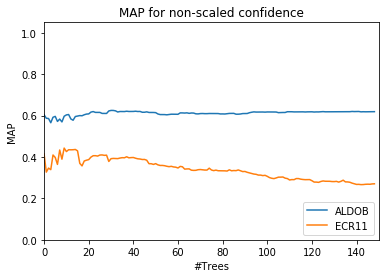

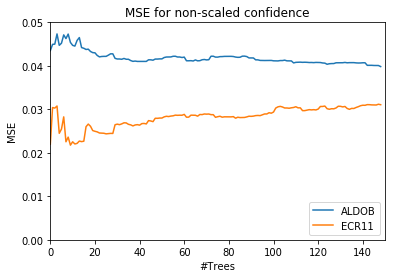

In [9]:
ylimits = {'map': 1.05, 'auc': 1.05, 'mse': 0.05, 'map_train': 1.05, 'auc_train': 1.05, 'mse_train': 0.4,
#            'mse-0.7': 0.05, 'mse-0.8': 0.05,'mse-0.9': 0.05, 
#            'mse-1.1': 0.05,'mse-1.2': 0.05, 'mse-1.3': 0.05, 
#            'mse-1.4': 0.05,'mse-1.5': 0.05, 'mse-1.6': 0.05,
          }
for metric in ['map', 'mse']:
    plt.figure()
    plt.xlim([0, num_trees_max])
    plt.ylim([0, ylimits[metric]])
    plt.xlabel('#Trees')
    plt.ylabel(metric.upper())
    plt.title(metric.upper() + title_suffix)
    for construction in curves.keys():
        plt.plot(curves[construction][metric], label=construction)
    plt.legend(loc="lower right")
    plt.savefig('qn-' + metric.upper() + figure_filename_suffix)
    plt.show()

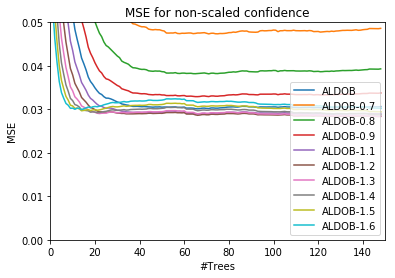

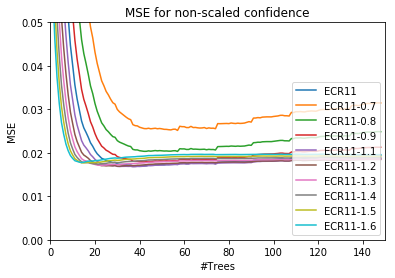

In [41]:
for construction in curves.keys():
    plt.figure()
    plt.xlim([0, num_trees_max])
    plt.ylim([0, 0.05])
    plt.xlabel('#Trees')
    plt.ylabel('MSE')
    plt.title('MSE' + title_suffix)

    plt.plot(curves[construction]['mse'], label=construction )
    plt.plot(curves[construction]['mse-0.7'], label=construction + '-0.7')
    plt.plot(curves[construction]['mse-0.8'], label=construction + '-0.8')
    plt.plot(curves[construction]['mse-0.9'], label=construction + '-0.9')
    plt.plot(curves[construction]['mse-1.1'], label=construction + '-1.1')
    plt.plot(curves[construction]['mse-1.2'], label=construction + '-1.2')
    plt.plot(curves[construction]['mse-1.3'], label=construction + '-1.3')
    plt.plot(curves[construction]['mse-1.4'], label=construction + '-1.4')
    plt.plot(curves[construction]['mse-1.5'], label=construction + '-1.5')
    plt.plot(curves[construction]['mse-1.6'], label=construction + '-1.6')
    plt.legend(loc="lower right")
    plt.savefig('MSE-pow-' + construction + '-non-scaled.png')
    plt.show()


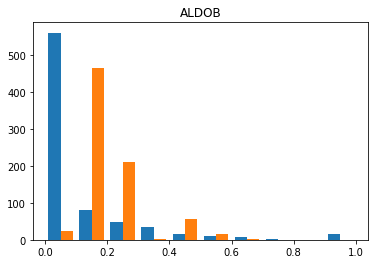

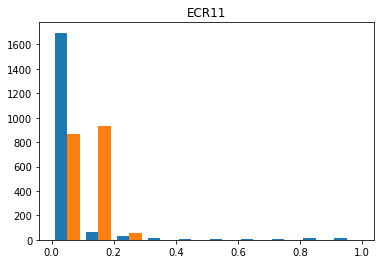

In [62]:

for construction in ['ALDOB', 'ECR11']:
    regression_infos = train_regression(
        DATA_TEST[DATA_TEST.construction==construction],
        DATA_TRAIN,
        normalizer=normalizer,
        denormalizer=denormalizer,
        classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=20, max_depth=3, n_jobs=-1)
    )
    plt.figure()
    plt.title(construction)
    plt.hist([regression_infos['y_test'], regression_infos['predictions_test']])



In [61]:
 import numpy as np
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores, average=None)

0.8333333333333333

In [2]:
def test_feature_subset(full_data, feature_types, constructions_to_test=CONSTRUCTONS, 
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1), 
                        useRegression=False):
    auc_results = {}
    for construction in constructions_to_test:
        data = filter_features_by_type(full_data, feature_types)
        train_data, test_data = split_by_construction(data, construction)
        X_train, y_train = split_features_and_target(train_data)
        X_test, y_test = split_features_and_target(test_data)

        if useRegression:
            y_train_to_fit = y_train
        else:
            y_train_to_fit = 0 + (y_train > 0.1)

        y_train_to_assess = 0 + (y_train > 0.1)
        y_test_to_assess = 0 + (y_test > 0.1)

        classifier = classifierBuilder()
        classifier.fit(X_train, y_train_to_fit)

        
        if useRegression:
            y_score_test = classifier.predict(X_test)
            y_score_train = classifier.predict(X_train)
        else:
            y_score_test = classifier.predict_proba(X_test)[:,1]
            y_score_train = classifier.predict_proba(X_train)[:,1]
        
        auc_results[construction] = get_rocs(
            [ (y_test_to_assess, y_score_test, 'test'), 
              (y_train_to_assess, y_score_train, 'train')],
            label='ROC for ' + construction,
            plot = True,
            filename = None)
        #print(construction, auc_results[construction], sep='\t', file = sys.stderr)

    print('Features:',feature_types, '\n')
    print('construction', 'test', 'train', sep='\t')
    print('-----------------------------\n')
    for k,v in sorted(auc_results.items()):
        print(k, round(v['test'], 4), round(v['train'], 4),sep='\t')
    print('AUC ROC values in constant order for test datasets:')
    for k,v in sorted(auc_results.items()):
        print(round(v['test'], 4))

In [3]:
def test_feature_subset_by_block(full_data, feature_types, constructions_to_test=CONSTRUCTONS, 
                                 classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                                 useRegression=False):
    auc_results = {}
    for construction in constructions_to_test:
        y_score_test_total = np.array([])
        y_score_train_total = np.array([])
        y_test_to_assess_total = np.array([])
        y_train_to_assess_total = np.array([])
        data = filter_features_by_type(full_data, feature_types)
        train_data_1, test_data_1 = split_by_construction(data, construction)
        for blocknum in np.unique(test_data_1['block_num']):
            train_data_2, test_data = split_by_block(test_data_1, blocknum)
            train_data = pd.concat([train_data_1, train_data_2])
            X_train, y_train = split_features_and_target(train_data)
            X_test, y_test = split_features_and_target(test_data)

            
            if useRegression:
                y_train_to_fit = y_train
            else:
                y_train_to_fit = 0 + (y_train > 0.1)
            y_train_to_assess = 0 + (y_train > 0.1)
            y_test_to_assess = 0 + (y_test > 0.1)

            classifier = classifierBuilder()
            classifier.fit(X_train, y_train_to_fit)

            if useRegression:
                y_score_test = classifier.predict(X_test)
                y_score_train = classifier.predict(X_train)
            else:
                y_score_test = classifier.predict_proba(X_test)[:,1]
                y_score_train = classifier.predict_proba(X_train)[:,1]
    
            y_score_test_total = np.hstack([y_score_test_total, y_score_test])
            y_score_train_total = np.hstack([y_score_train_total, y_score_train])
            y_test_to_assess_total = np.hstack([y_test_to_assess_total, y_test_to_assess])
            y_train_to_assess_total = np.hstack([y_train_to_assess_total, y_train_to_assess])
        
        auc_results[construction] = get_rocs(
            [ (y_test_to_assess_total, y_score_test_total, 'test'), 
              (y_train_to_assess_total, y_score_train_total, 'train')],
            label='ROC for ' + construction,
            plot = True,
            filename = None)
        #print(construction, auc_results[construction], sep='\t', file = sys.stderr)

    print('Features:',feature_types, '\n')
    print('construction', 'test', 'train', sep='\t')
    print('-----------------------------\n')
    for k,v in sorted(auc_results.items()):
        print(k, round(v['test'], 4), round(v['train'], 4),sep='\t')
    print('AUC ROC values in constant order for test datasets:')
    for k,v in sorted(auc_results.items()):
        print(round(v['test'], 4))
        

In [47]:
def train_and_test_feature_subset(test_data, train_data,
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1), 
                        useRegression=False):
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)

    if useRegression:
        y_train_to_fit = y_train
    else:
        y_train_to_fit = 0 + (y_train > 0.1)

    y_train_to_assess = 0 + (y_train > 0.1)
    y_test_to_assess = 0 + (y_test > 0.1)

    classifier = classifierBuilder()
    classifier.fit(X_train, y_train_to_fit)


    if useRegression:
        y_score_test = classifier.predict(X_test)
        y_score_train = classifier.predict(X_train)
    else:
        y_score_test = classifier.predict_proba(X_test)[:,1]
        y_score_train = classifier.predict_proba(X_train)[:,1]

    auc_results = get_rocs(
        [ (y_test_to_assess, y_score_test, 'test'), 
          (y_train_to_assess, y_score_train, 'train')],
        label='ROC',
        plot = True,
        filename = None)
    return auc_results['test']

In [5]:
def test_by_block(data,
                classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                useRegression=False):
    
    y_score_test_total = np.array([])
    y_score_train_total = np.array([])
    y_test_to_assess_total = np.array([])
    y_train_to_assess_total = np.array([])
    
    for blocknum in np.unique(data['block_num']):
        train_data, test_data = split_by_block(data, blocknum)
        X_train, y_train = split_features_and_target(train_data)
        X_test, y_test = split_features_and_target(test_data)


        if useRegression:
            y_train_to_fit = y_train
        else:
            y_train_to_fit = 0 + (y_train > 0.1)
        y_train_to_assess = 0 + (y_train > 0.1)
        y_test_to_assess = 0 + (y_test > 0.1)

        classifier = classifierBuilder()
        classifier.fit(X_train, y_train_to_fit)

        if useRegression:
            y_score_test = classifier.predict(X_test)
            y_score_train = classifier.predict(X_train)
        else:
            y_score_test = classifier.predict_proba(X_test)[:,1]
            y_score_train = classifier.predict_proba(X_train)[:,1]

        y_score_test_total = np.hstack([y_score_test_total, y_score_test])
        y_score_train_total = np.hstack([y_score_train_total, y_score_train])
        y_test_to_assess_total = np.hstack([y_test_to_assess_total, y_test_to_assess])
        y_train_to_assess_total = np.hstack([y_train_to_assess_total, y_train_to_assess])

    aucs = get_rocs(
        [ (y_test_to_assess_total, y_score_test_total, 'test'), 
          (y_train_to_assess_total, y_score_train_total, 'train')],
        label='ROC',
        plot = False,
        filename = None)
    return aucs
        

In [181]:
def test_datasets(train_data, test_data,
        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
        useRegression=False, plot=True):
    
    X_train, y_train = split_features_and_target(train_data)
    X_test, y_test = split_features_and_target(test_data)

    if useRegression:
        y_train_to_fit = y_train
    else:
        y_train_to_fit = 0 + (y_train > 0.1)
    y_train_to_assess = 0 + (y_train > 0.1)
    y_test_to_assess = 0 + (y_test > 0.1)

    classifier = classifierBuilder()
    classifier.fit(X_train, y_train_to_fit)

    if useRegression:
        y_score_test = classifier.predict(X_test)
        y_score_train = classifier.predict(X_train)
    else:
        y_score_test = classifier.predict_proba(X_test)[:,1]
        y_score_train = classifier.predict_proba(X_train)[:,1]

    aucs = get_rocs(
        [ (y_test_to_assess, y_score_test, 'test'), 
          (y_train_to_assess, y_score_train, 'train')],
        label='ROC',
        plot = plot,
        filename = None)
    return aucs
        

. . . . . . . . . . . . . . . . . . . . 

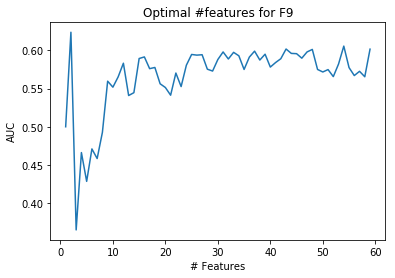

. . . . . . . . . . . . . . . . . . . . 

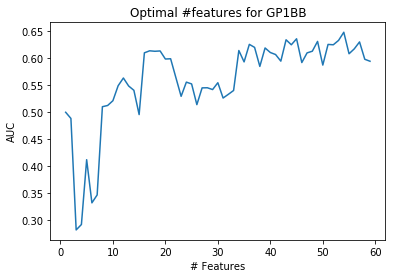

. . . . . . . . . . . . . . . . . . . . 

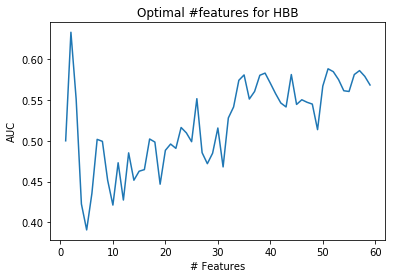

. . . . . . . . . . . . . . . . . . . . 

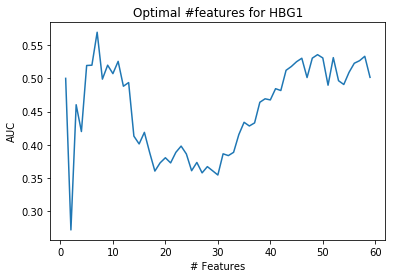

. . . . . . . . . . . . . . . . . . . . 

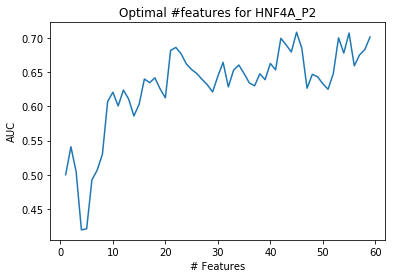

. . . . . . . . . . . . . . . . . . . . 

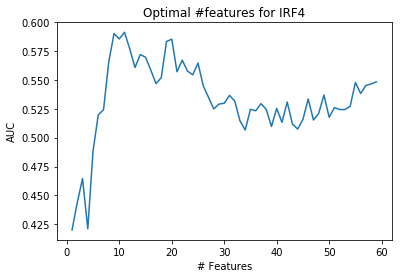

. . . . . 

KeyboardInterrupt: 

In [186]:
plots_by_construction = {}
for test_construction in CONSTRUCTONS:
    feature_names = split_features_and_target(FULL_DATA)[0].keys()
    data_train = FULL_DATA[FULL_DATA.construction != test_construction]
    data_test = FULL_DATA[FULL_DATA.construction == test_construction]
    feature_importances = np.zeros( (len(feature_names),) )
    for i in range(20):
        print('.', end=' ')
        classifier = xgb.XGBClassifier(max_depth=3, n_estimators=100)
        X, y = split_features_and_target( data_train.sample(frac=0.5) )
        y = 0 + (y > 0.1) 
        classifier.fit(X, y)
        feature_importances += classifier.feature_importances_
    features_w_importances_sorted = list(sorted(zip(feature_names,feature_importances), key=lambda kv: -kv[1]))
    features_sorted = list(map(lambda kv: kv[0], features_w_importances_sorted))
#     print('\n'.join(features_sorted[0:25]))

    xs = []
    aucs = []
    for num_features in range(1,60):
        best_features = features_sorted[0:num_features]
        xs.append(num_features)
        auc_infos = test_datasets(filter_features(data_train, lambda f: f in best_features),
                                  filter_features(data_test, lambda f: f in best_features),
                                  plot=False)
        aucs.append(auc_infos['test'])
#         print(num_features,end=' ')
    plots_by_construction[test_construction] = (xs,aucs)
    plt.figure()
    plt.plot(xs, aucs)
    plt.xlabel('# Features')
    plt.ylabel('AUC')
    plt.title('Optimal #features for ' + test_construction)
    plt.show()
#     print('\n'.join(map(lambda rec: rec[0] + '\t'+ str(rec[1]),features_w_importances_sorted[0:25])))


In [13]:
def select_data_by(data, key, values):
    if values == 'all':
        return data
    else:
        results = []
        for value in values:
            results.append(data[ data[key] == value ])
        return pd.concat(results)

def reject_data_by(data, key, values):
    if values == 'all':
        return pd.DataFrame(columns=data.keys())
    else:
        results = []
        for value in np.unique(data[key]):
            if value not in values:
                results.append(data[ data[key] == value ])
        return pd.concat(results)

reject_data_by(FULL_DATA, 'construction', ['TERT_GBM','F9','ZFAND3'])

,SNV,construction,value,confidence,ANDR_HUMAN.H11DI.0.A:pval_1_best,ANDR_HUMAN.H11DI.0.A:fc_samepos,AP2A_HUMAN.H11DI.0.A:pval_1_best,AP2A_HUMAN.H11DI.0.A:fc_samepos,AP2C_HUMAN.H11DI.0.A:pval_1_best,AP2C_HUMAN.H11DI.0.A:fc_samepos,...,gerp_rs,phyloP100way,phyloP46way,phastCons46way,phastCons100way,mz46_log_diff,mz100_log_diff,mz46_log_diff.hg19.75,mz100_log_diff.hg19.75,block_num
234,GP1BB@19710804@T/A,GP1BB,0.01,0.00,1.728622,-5.278947,0.866062,0.409091,0.752105,0.571429,...,0.714,0.780,0.459,0.891,0.123,-2.322388,-2.745438,-2.322388,-2.745438,4
235,GP1BB@19710804@T/C,GP1BB,0.06,0.01,1.728622,-5.642105,0.866062,-0.424242,0.752105,0.000000,...,0.714,0.780,0.459,0.891,0.123,-2.322388,-1.472472,-2.322388,-1.472472,4
236,GP1BB@19710804@T/G,GP1BB,0.05,0.00,1.728622,-7.984211,0.866062,2.109848,0.752105,2.516484,...,0.714,0.780,0.459,0.891,0.123,-3.931826,-3.592736,-3.931826,-3.592736,4
237,GP1BB@19710805@C/A,GP1BB,-0.10,0.02,1.728622,0.500000,0.866062,0.443182,0.752105,0.000000,...,3.280,2.894,0.561,0.924,0.185,-2.360854,-4.919981,-2.360854,-4.919981,4
238,GP1BB@19710805@C/G,GP1BB,-0.14,0.01,1.728622,-0.136842,0.866062,3.174242,0.752105,3.796703,...,3.280,2.894,0.561,0.924,0.185,-2.871680,-3.310543,-2.871680,-3.310543,4
239,GP1BB@19710805@C/T,GP1BB,-0.06,0.02,1.728622,1.931579,0.866062,0.443182,0.752105,0.000000,...,3.280,2.894,0.561,0.924,0.185,-3.970292,-4.919981,-3.970292,-4.919981,4
240,GP1BB@19710806@C/A,GP1BB,0.14,0.08,1.728622,-5.915789,1.175027,-0.083333,1.288947,0.000000,...,3.380,1.056,0.561,0.945,0.101,-2.908721,-3.265759,-2.908721,-3.265759,4
241,GP1BB@19710806@C/G,GP1BB,-0.02,0.00,1.728622,-6.710526,1.175027,-0.162879,1.288947,-0.049451,...,3.380,1.056,0.561,0.945,0.101,-4.007333,-3.776585,-4.007333,-3.776585,4
242,GP1BB@19710806@C/T,GP1BB,-0.09,0.04,1.728622,-4.231579,1.175027,-0.132576,1.288947,-0.335165,...,3.380,1.056,0.561,0.945,0.101,-2.908721,-3.265759,-2.908721,-3.265759,4
243,GP1BB@19710807@T/A,GP1BB,-0.10,0.02,1.728622,-3.800000,1.175027,-0.882576,1.288947,-0.879121,...,4.400,0.054,0.459,0.960,0.026,-2.944439,-3.713572,-2.944439,-3.713572,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

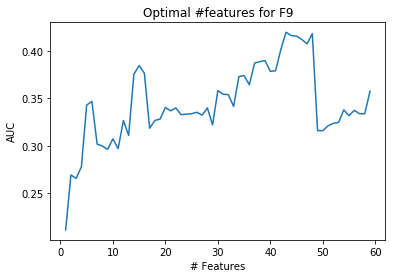

NFIA_HUMAN.H11MO.1.D:fc_samepos	0.797507837415
TAF1_HUMAN.H11MO.0.A:fc_samepos	0.68144553341
CREB1_HUMAN.H11DI.0.A:fc_samepos	0.624664800242
TCF7_HUMAN.H11DI.0.A:fc_samepos	0.533741417341
Nuclear factor 1{7.1.2}:stddev_fc	0.452496100217
Jun-related factors{1.1.1}:stddev_fc	0.448666855693
VENTX_HUMAN.H11MO.0.D:fc_samepos	0.32679371722
NGFI-B-related receptors (NR4){2.1.4}:median_fc	0.305534576066
NF-kappaB-related factors{6.1.1}:stddev_fc	0.292671844363
EPAS1_HUMAN.H11DI.0.B:fc_samepos	0.292465999722
TYY1_HUMAN.H11DI.0.A:fc_samepos	0.268470129929
HMX3_HUMAN.H11MO.0.D:fc_samepos	0.266931481659
IRF5_HUMAN.H11MO.0.D:fc_samepos	0.258620689623
FOXD1_HUMAN.H11MO.0.D:fc_samepos	0.257164619863
LHX9_HUMAN.H11MO.0.D:fc_samepos	0.24202599097
MITF_HUMAN.H11MO.0.A:fc_samepos	0.236676010303
mz100_log_diff	0.23401665967
HXB4_HUMAN.H11DI.0.B:fc_samepos	0.226752166636
NR2E3_HUMAN.H11MO.0.C:fc_samepos	0.21456334088
BARH2_HUMAN.H11MO.0.D:fc_samepos	0.209302321076
SOX21_HUMAN.H11MO.0.D:fc_samepos	0.2075581

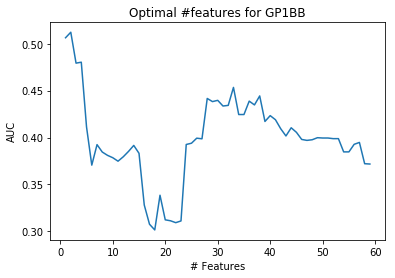

RXR-related receptors (NR2){2.1.3}:stddev_fc	0.793120814487
DLX2_HUMAN.H11MO.0.D:fc_samepos	0.431818179786
PO4F3_HUMAN.H11MO.0.D:fc_samepos	0.419349534437
EPAS1_HUMAN.H11MO.0.B:fc_samepos	0.37704386143
RUNX2_HUMAN.H11MO.0.A:fc_samepos	0.355089049786
ZN335_HUMAN.H11DI.0.A:fc_samepos	0.320537103806
NOBOX_HUMAN.H11MO.0.C:fc_samepos	0.283129384741
LHX2_HUMAN.H11DI.0.A:fc_samepos	0.277738484554
SPIB_HUMAN.H11MO.0.A:fc_samepos	0.267421618104
TWST1_HUMAN.H11MO.1.A:fc_samepos	0.256559835747
Paired plus homeo domain{3.2.1}:median_fc	0.245757916942
STAT2_HUMAN.H11DI.0.A:fc_samepos	0.230921521317
Steroid hormone receptors (NR3){2.1.1}:stddev_fc	0.230308470316
ZN320_HUMAN.H11DI.0.C:fc_samepos	0.228783092927
TF65_HUMAN.H11MO.0.A:fc_samepos	0.194985036738
NKX61_HUMAN.H11MO.1.B:fc_samepos	0.183555346448
ZN134_HUMAN.H11MO.1.C:fc_samepos	0.169749808498
ZN528_HUMAN.H11MO.0.C:fc_samepos	0.168739460409
SMAD1_HUMAN.H11MO.0.D:fc_samepos	0.166953769047
TWST1_HUMAN.H11MO.0.A:fc_samepos	0.158123711124
NKX32_HU

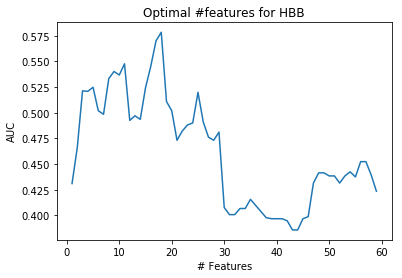

HTF4_HUMAN.H11DI.0.A:fc_samepos	2.58381539583
ASCL1_HUMAN.H11DI.0.A:fc_samepos	1.53265347704
ZN582_HUMAN.H11DI.0.C:fc_samepos	1.14141412079
ZN134_HUMAN.H11MO.1.C:fc_samepos	1.04545454681
ZN394_HUMAN.H11MO.0.C:fc_samepos	0.838752064854
MYB_HUMAN.H11DI.0.A:fc_samepos	0.651382006705
LEF1_HUMAN.H11DI.0.A:fc_samepos	0.64135402441
ELK3_HUMAN.H11MO.0.D:fc_samepos	0.423076927662
ZN335_HUMAN.H11DI.0.A:fc_samepos	0.347552452236
PO4F2_HUMAN.H11MO.0.D:fc_samepos	0.345289859921
ZN134_HUMAN.H11MO.0.C:fc_samepos	0.268518522382
ARNT_HUMAN.H11DI.0.B:fc_samepos	0.266666680574
Fos-related factors{1.1.2}:stddev_fc	0.259740263224
ZN322_HUMAN.H11MO.0.B:fc_samepos	0.25698005408
NFIB_HUMAN.H11MO.0.D:fc_samepos	0.25555555895
HD-LIM factors{3.1.5}:stddev_fc	0.233333334327
HXD13_HUMAN.H11MO.0.D:fc_samepos	0.219943024218
OTX2_HUMAN.H11DI.0.A:fc_samepos	0.218518514186
TALE-type homeo domain factors{3.1.4}:stddev_fc	0.218518514186
TBP_HUMAN.H11MO.0.A:fc_samepos	0.191666670144
PRDM6_HUMAN.H11MO.0.C:fc_samepos	0.1851

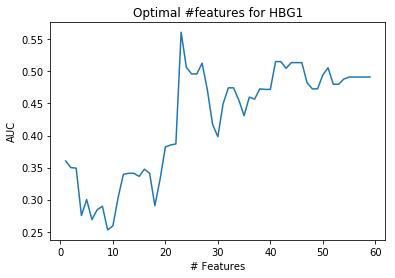

HMGA1_HUMAN.H11MO.0.D:pval_1_best	0.980022443924
NFYC_HUMAN.H11DI.0.A:fc_samepos	0.707740439102
PO5F1_HUMAN.H11MO.1.A:fc_samepos	0.507918576244
AIRE_HUMAN.H11MO.0.C:fc_samepos	0.486302389763
DLX2_HUMAN.H11MO.0.D:pval_1_best	0.379054618999
PO6F2_HUMAN.H11MO.0.D:fc_samepos	0.356706002261
ZN232_HUMAN.H11MO.0.D:fc_samepos	0.337065657601
NKX22_HUMAN.H11DI.0.B:pval_1_best	0.307129970286
DMRT1_HUMAN.H11DI.0.D:fc_samepos	0.302714645863
LHX6_HUMAN.H11MO.0.D:fc_samepos	0.290455449373
JUND_HUMAN.H11DI.0.A:fc_samepos	0.287242779043
SOX15_HUMAN.H11MO.0.D:pval_1_best	0.242786093149
GBX2_HUMAN.H11MO.0.D:fc_samepos	0.202687161975
HXD9_HUMAN.H11MO.0.D:pval_1_best	0.198048606981
phyloP100way	0.188340459485
OZF_HUMAN.H11MO.0.C:fc_samepos	0.17334032245
PRRX1_HUMAN.H11MO.0.D:fc_samepos	0.172742310911
SIX1_HUMAN.H11MO.0.A:fc_samepos	0.162159234285
KAISO_HUMAN.H11MO.2.A:fc_samepos	0.156154215336
PRGR_HUMAN.H11DI.0.A:fc_samepos	0.15306607401
OZF_HUMAN.H11DI.0.C:fc_samepos	0.152208445594
EHF_HUMAN.H11DI.0.B:fc

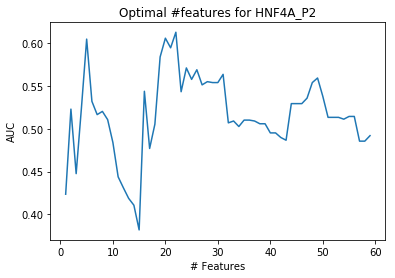

RFX-related factors{3.3.3}:stddev_fc	0.440735982731
ASCL2_HUMAN.H11DI.0.D:fc_samepos	0.293233092874
LEF1_HUMAN.H11MO.0.A:fc_samepos	0.286875732243
FEZF1_HUMAN.H11DI.0.C:fc_samepos	0.266733907163
ATF1_HUMAN.H11DI.0.B:fc_samepos	0.234335841611
ATF4_HUMAN.H11DI.0.A:fc_samepos	0.224891500548
NFKB2_HUMAN.H11DI.0.B:fc_samepos	0.221040405333
BSH_HUMAN.H11MO.0.D:fc_samepos	0.219878971577
ZFX_HUMAN.H11MO.1.A:fc_samepos	0.195305336267
VDR_HUMAN.H11DI.0.A:fc_samepos	0.195305334404
CEBPG_HUMAN.H11DI.0.B:fc_samepos	0.193379787728
GATA3_HUMAN.H11DI.0.A:fc_samepos	0.175346903503
CEBPA_HUMAN.H11DI.0.A:fc_samepos	0.172840639949
DLX6_HUMAN.H11MO.0.D:fc_samepos	0.167247388512
ZN667_HUMAN.H11MO.0.C:fc_samepos	0.166666671634
MITF_HUMAN.H11MO.0.A:fc_samepos	0.150375941768
CEBPB_HUMAN.H11DI.0.A:fc_samepos	0.149031113833
ZN260_HUMAN.H11DI.0.C:fc_samepos	0.147686285898
ZN257_HUMAN.H11DI.0.C:fc_samepos	0.147105567157
Paired-related HD factors{3.1.3}:stddev_fc	0.145760739222
NR2E3_HUMAN.H11MO.0.C:fc_samepos	0.14

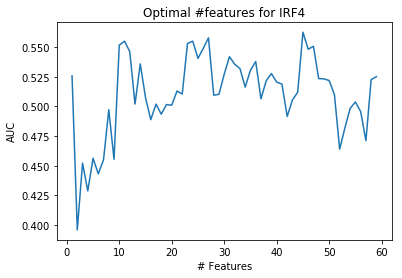

Three-zinc finger Krüppel-related factors{2.3.1}:stddev_fc	0.454923545942
BATF3_HUMAN.H11MO.0.B:pval_1_best	0.419819478644
Steroid hormone receptors (NR3){2.1.1}:stddev_fc	0.220277530607
BACH2_HUMAN.H11MO.0.A:pval_1_best	0.204974506749
Z324A_HUMAN.H11DI.0.C:fc_samepos	0.203202225268
HXA7_HUMAN.H11MO.0.D:fc_samepos	0.186481053475
OLIG1_HUMAN.H11MO.0.D:pval_1_best	0.183115825756
ZN214_HUMAN.H11MO.0.C:pval_1_best	0.161627140129
NRL_HUMAN.H11MO.0.D:fc_samepos	0.161368123721
OLIG3_HUMAN.H11MO.0.D:fc_samepos	0.141304484801
MAFF_HUMAN.H11MO.0.B:fc_samepos	0.14116139058
STA5B_HUMAN.H11DI.0.A:fc_samepos	0.137449788628
EGR2_HUMAN.H11MO.0.A:fc_samepos	0.136884759879
USF2_HUMAN.H11MO.0.A:fc_samepos	0.133487070212
RXR-related receptors (NR2){2.1.3}:stddev_fc	0.129167401232
Nuclear factor 1{7.1.2}:stddev_fc	0.128808741458
KLF3_HUMAN.H11DI.0.B:fc_samepos	0.116420718143
KAISO_HUMAN.H11MO.2.A:fc_samepos	0.113198808394
Tal-related factors{1.2.3}:stddev_fc	0.112338877516
OSR2_HUMAN.H11MO.0.C:fc_samepos	0

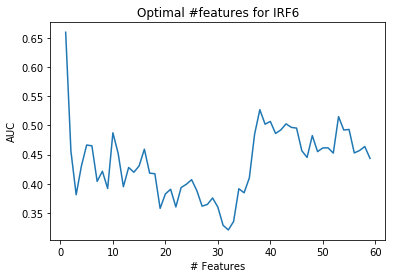

NGN2_HUMAN.H11MO.0.D:pval_1_best	0.290408616886
OSR2_HUMAN.H11DI.0.C:fc_samepos	0.263683858328
ASCL2_HUMAN.H11DI.0.D:pval_1_best	0.253909816034
p53-related factors{6.3.1}:median_fc	0.24555949308
MXI1_HUMAN.H11DI.0.A:fc_samepos	0.21880528098
P63_HUMAN.H11MO.1.A:fc_samepos	0.199716675561
RUNX2_HUMAN.H11DI.0.A:fc_samepos	0.186071525794
PO3F1_HUMAN.H11MO.0.C:fc_samepos	0.180635367753
ZN264_HUMAN.H11DI.0.C:fc_samepos	0.16703393124
CTCFL_HUMAN.H11DI.0.A:fc_samepos	0.161879846361
ZN563_HUMAN.H11DI.0.C:fc_samepos	0.150740905199
CLOCK_HUMAN.H11MO.0.C:fc_samepos	0.149547571782
TBX2-related factors{6.5.4}:stddev_fc	0.148426687345
NKX22_HUMAN.H11MO.0.D:fc_samepos	0.14556356566
ATOH1_HUMAN.H11DI.0.B:fc_samepos	0.140387092717
MYNN_HUMAN.H11MO.0.D:fc_samepos	0.139210920082
ATF3_HUMAN.H11DI.0.A:fc_samepos	0.138793589082
ZN582_HUMAN.H11MO.0.C:fc_samepos	0.127269890625
P53_HUMAN.H11MO.1.A:fc_samepos	0.12687622197
MYOG_HUMAN.H11MO.0.B:fc_samepos	0.124831332359
FUBP1_HUMAN.H11MO.0.D:fc_samepos	0.124244031

KeyboardInterrupt: 

In [171]:
def filter_by_block_numbers(data, block_nums):
    results = []
    for block_num in block_nums:
        results.append(data[data.block_num == block_num])
    return pd.concat(results)
    
feature_importances_sorted_by_construction = {}
plots_by_construction = {}
for construction in CONSTRUCTONS:
    data = FULL_DATA[FULL_DATA.construction==construction]
    del data['mz46_pre']
    del data['mz100_pre']
    feature_names = split_features_and_target(data)[0].keys()
    
    train_blocks, test_blocks = sklearn.model_selection.train_test_split(np.unique(data.block_num), train_size=0.5)
    data_train = filter_by_block_numbers(data, train_blocks)
    data_test = filter_by_block_numbers(data, test_blocks)
    
    feature_importances = np.zeros( (len(feature_names),) )
    for i in range(20):
        classifier = xgb.XGBClassifier(max_depth=3, n_estimators=100)
        X, y = split_features_and_target( data_train.sample(frac=0.5) )
        y = 0 + (y > 0.1) 
        classifier.fit(X, y)
        feature_importances += classifier.feature_importances_

    xs = []
    aucs = []
    features_w_importances_sorted = list(sorted(zip(feature_names,feature_importances), key=lambda kv: -kv[1]))
    feature_importances_sorted_by_construction[construction] = features_w_importances_sorted
    features_sorted = list(map(lambda kv: kv[0], features_w_importances_sorted))
    for num_features in range(1,60):
        best_features = features_sorted[0:num_features]
        xs.append(num_features)
        aucs.append(test_by_block(filter_features(data_test, lambda f: f in best_features))['test'])
        print(num_features,end=' ')
    plots_by_construction[construction] = (xs,aucs)
    plt.figure()
    plt.plot(xs, aucs)
    plt.xlabel('# Features')
    plt.ylabel('AUC')
    plt.title('Optimal #features for ' + construction)
    plt.show()
    print('\n'.join(map(lambda rec: rec[0] + '\t'+ str(rec[1]),features_w_importances_sorted[0:25])))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

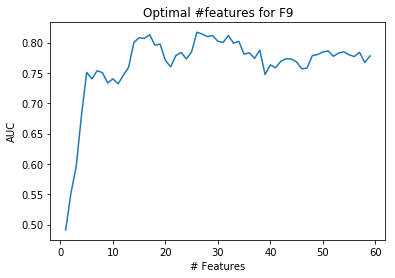

TYY1_HUMAN.H11DI.0.A:fc_samepos	0.407821235713
HMX1_HUMAN.H11MO.0.D:fc_samepos	0.365672783926
FOXD1_HUMAN.H11MO.0.D:fc_samepos	0.362601011293
ZIC2_HUMAN.H11MO.0.D:fc_samepos	0.318130163942
mz100_log_diff	0.311380830593
MAZ_HUMAN.H11DI.0.A:fc_samepos	0.306735182647
Brachyury-related factors{6.5.1}:median_fc	0.282382181613
SP4_HUMAN.H11DI.0.A:fc_samepos	0.281752911163
TAF1_HUMAN.H11MO.0.A:fc_samepos	0.245457134675
CEBPB_HUMAN.H11DI.0.A:fc_samepos	0.227103987709
NKX31_HUMAN.H11DI.0.A:fc_samepos	0.222156441072
FOXK1_HUMAN.H11DI.0.A:fc_samepos	0.217183433706
Early B-Cell Factor-related factors{6.1.5}:stddev_fc	0.214683532715
BPTF_HUMAN.H11MO.0.D:fc_samepos	0.212838955922
EGR3_HUMAN.H11MO.0.D:fc_samepos	0.194576222682
FOXG1_HUMAN.H11MO.0.D:fc_samepos	0.194572634762
NKX22_HUMAN.H11MO.0.D:fc_samepos	0.189808990108
TCF-7-related factors{4.1.3}:stddev_fc	0.178307624068
RFX5_HUMAN.H11MO.0.A:fc_samepos	0.167529594852
LYL1_HUMAN.H11DI.0.A:fc_samepos	0.163008440053
TCF7_HUMAN.H11DI.0.A:fc_samepos	0.

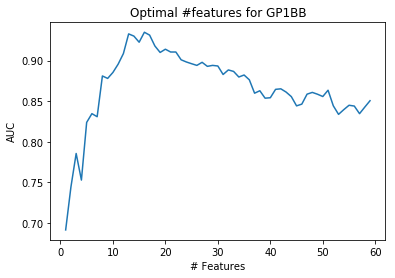

RXR-related receptors (NR2){2.1.3}:stddev_fc	1.24876496941
Tal-related factors{1.2.3}:stddev_fc	0.879406371154
POU domain factors{3.1.10}:stddev_fc	0.422395762056
PO4F3_HUMAN.H11MO.0.D:fc_samepos	0.402197246673
FTZ-F1-related receptors (NR5){2.1.5}:median_pval	0.363270141184
NF-kappaB-related factors{6.1.1}:stddev_fc	0.360784004442
HXA7_HUMAN.H11MO.0.D:fc_samepos	0.360145639628
ERR1_HUMAN.H11DI.0.A:fc_samepos	0.336224944331
More than 3 adjacent zinc finger factors{2.3.3}:stddev_fc	0.239747590851
HIF1A_HUMAN.H11DI.0.C:pval_1_best	0.212041323073
STF1_HUMAN.H11DI.0.B:pval_1_best	0.169006353477
Steroid hormone receptors (NR3){2.1.1}:stddev_fc	0.16774891247
HXA5_HUMAN.H11MO.0.D:fc_samepos	0.164652845357
SOX2_HUMAN.H11MO.1.A:fc_samepos	0.159561281092
TAL1_HUMAN.H11DI.0.A:fc_samepos	0.159424843499
THAP1_HUMAN.H11DI.0.C:pval_1_best	0.139615069143
ZN331_HUMAN.H11MO.0.C:fc_samepos	0.13921812363
SMAD1_HUMAN.H11MO.0.D:fc_samepos	0.138443208067
NANOG_HUMAN.H11DI.0.A:fc_samepos	0.128788966686
NR5A2_

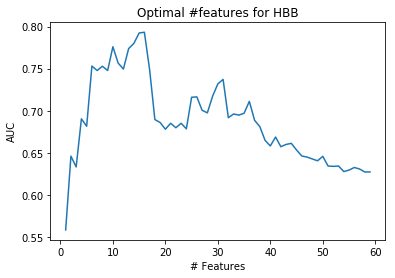

ZN282_HUMAN.H11MO.0.D:fc_samepos	0.852449555881
TWST1_HUMAN.H11MO.0.A:fc_samepos	0.565986775327
ZNF41_HUMAN.H11MO.0.C:fc_samepos	0.453624895774
PITX3_HUMAN.H11MO.0.D:fc_samepos	0.436819214374
ZN549_HUMAN.H11MO.0.C:fc_samepos	0.424800556619
ZN250_HUMAN.H11DI.0.C:fc_samepos	0.341109742876
ZN134_HUMAN.H11MO.0.C:fc_samepos	0.305108732311
ZNF41_HUMAN.H11DI.0.C:fc_samepos	0.293855981436
CUX1_HUMAN.H11MO.0.C:fc_samepos	0.284755160101
NFIC_HUMAN.H11MO.1.A:fc_samepos	0.236830629176
ETS2_HUMAN.H11MO.0.B:fc_samepos	0.234526871704
ZN582_HUMAN.H11DI.0.C:fc_samepos	0.221314620925
HIF1A_HUMAN.H11MO.0.C:fc_samepos	0.219370195642
SUH_HUMAN.H11DI.0.A:fc_samepos	0.217862867052
ZBT48_HUMAN.H11MO.0.C:fc_samepos	0.213783459272
HXA7_HUMAN.H11MO.0.D:fc_samepos	0.207205286715
HD-ZF factors{3.1.8}:stddev_fc	0.205734870164
SOX4_HUMAN.H11MO.0.B:fc_samepos	0.198805365246
ELK1_HUMAN.H11DI.0.B:fc_samepos	0.198609317653
SOX9_HUMAN.H11MO.1.B:pval_1_best	0.192320626229
XBP1_HUMAN.H11MO.0.D:fc_samepos	0.186342959292
OZF

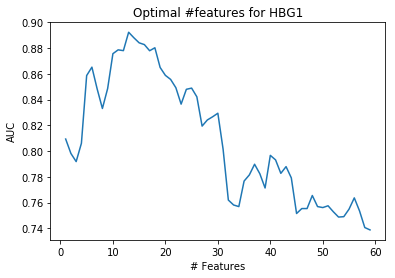

ZBT7B_HUMAN.H11MO.0.D:pval_1_best	0.661318073981
PRGR_HUMAN.H11DI.0.A:fc_samepos	0.341695753159
PBX1_HUMAN.H11MO.0.A:fc_samepos	0.336553822737
FOXA1_HUMAN.H11DI.0.A:fc_samepos	0.293126386125
ZNF85_HUMAN.H11MO.0.C:fc_samepos	0.256946215406
CREM_HUMAN.H11MO.0.C:pval_1_best	0.247817516327
DMRT1_HUMAN.H11DI.0.D:fc_samepos	0.246648832457
AIRE_HUMAN.H11MO.0.C:fc_samepos	0.216041496955
USF2_HUMAN.H11MO.0.A:fc_samepos	0.20396391023
OZF_HUMAN.H11MO.0.C:fc_samepos	0.202684774762
HD-CUT factors{3.1.9}:stddev_fc	0.187149730278
AHR_HUMAN.H11MO.0.B:fc_samepos	0.185179957654
phastCons100way	0.182109251386
KAISO_HUMAN.H11MO.0.A:pval_1_best	0.178196103079
CREB1_HUMAN.H11DI.0.A:pval_1_best	0.166987072444
ZN547_HUMAN.H11MO.0.C:fc_samepos	0.156609298661
NOBOX_HUMAN.H11MO.0.C:fc_samepos	0.149164212402
SRF_HUMAN.H11MO.0.A:pval_1_best	0.148418775527
TCF7_HUMAN.H11DI.0.A:fc_samepos	0.148217667593
ZN547_HUMAN.H11DI.0.C:fc_samepos	0.147639114177
PDX1_HUMAN.H11MO.0.A:fc_samepos	0.146334956633
Hairy-related facto

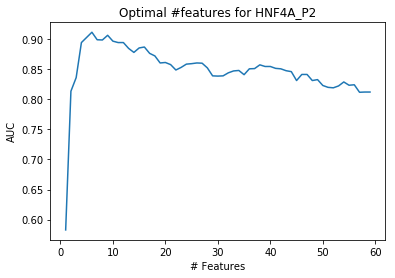

CREB-related factors{1.1.7}:stddev_fc	0.97916154284
HMGA factors{8.2.1}:median_fc	0.918254607357
KLF15_HUMAN.H11MO.0.A:fc_samepos	0.793842579704
ZN121_HUMAN.H11DI.0.C:fc_samepos	0.566075159702
NDF2_HUMAN.H11DI.0.B:fc_samepos	0.4879638087
IRF9_HUMAN.H11MO.0.C:fc_samepos	0.482550746761
ELF3_HUMAN.H11DI.0.A:fc_samepos	0.453534336761
ZN121_HUMAN.H11MO.0.C:fc_samepos	0.338507553563
SMAD3_HUMAN.H11DI.0.C:fc_samepos	0.317220523488
MITF_HUMAN.H11MO.0.A:fc_samepos	0.313578540459
HMGA2_HUMAN.H11MO.0.D:fc_samepos	0.283723419532
Hairy-related factors{1.2.4}:stddev_fc	0.25925820088
ANDR_HUMAN.H11DI.0.A:fc_samepos	0.250150340144
TFE2_HUMAN.H11MO.0.A:fc_samepos	0.233204703312
ZN708_HUMAN.H11MO.0.C:fc_samepos	0.230186133645
SRBP1_HUMAN.H11MO.0.A:fc_samepos	0.227235390339
MAZ_HUMAN.H11MO.0.A:fc_samepos	0.226220735349
ZBT7A_HUMAN.H11DI.0.A:fc_samepos	0.21737013245
CREB1_HUMAN.H11DI.0.A:fc_samepos	0.210478460416
USF2_HUMAN.H11MO.0.A:fc_samepos	0.202800135594
Factors with multiple dispersed zinc fingers{2

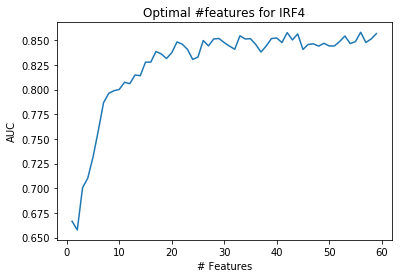

ZN214_HUMAN.H11MO.0.C:pval_1_best	0.298471388174
FOXF2_HUMAN.H11MO.0.D:fc_samepos	0.224729863228
Three-zinc finger Krüppel-related factors{2.3.1}:stddev_fc	0.215917170513
HD-ZF factors{3.1.8}:stddev_fc	0.209624671494
Steroid hormone receptors (NR3){2.1.1}:stddev_fc	0.207861180068
KLF4_HUMAN.H11MO.0.A:fc_samepos	0.174134017434
CDX2_HUMAN.H11MO.0.A:fc_samepos	0.157222143025
Z324A_HUMAN.H11DI.0.C:fc_samepos	0.154215256334
CSL-related factors{6.1.4}:stddev_fc	0.153908580425
SOX17_HUMAN.H11MO.0.C:fc_samepos	0.151081883698
E2F-related factors{3.3.2}:stddev_fc	0.142521772301
FOXC2_HUMAN.H11MO.0.D:fc_samepos	0.13631115586
ZN331_HUMAN.H11MO.0.C:fc_samepos	0.132891785819
Tal-related factors{1.2.3}:stddev_fc	0.131667882903
MAF_HUMAN.H11MO.0.A:fc_samepos	0.131606101291
ZN335_HUMAN.H11MO.1.A:fc_samepos	0.120405679801
SALL4_HUMAN.H11MO.0.B:pval_1_best	0.116994390148
HMX2_HUMAN.H11MO.0.D:fc_samepos	0.115387819707
EPAS1_HUMAN.H11MO.0.B:fc_samepos	0.113365568453
RFX-related factors{3.3.3}:stddev_fc	0.1

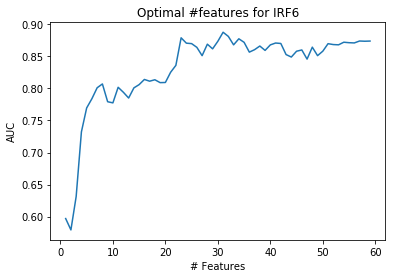

ETS1_HUMAN.H11MO.0.A:fc_samepos	0.311958803562
NGFI-B-related receptors (NR4){2.1.4}:stddev_fc	0.300156182959
Regulators of differentiation{5.1.1}:stddev_fc	0.277928664116
p53-related factors{6.3.1}:stddev_pval	0.243898180313
P73_HUMAN.H11DI.0.A:fc_samepos	0.219218894606
P63_HUMAN.H11DI.0.A:fc_samepos	0.199582786299
IKZF1_HUMAN.H11MO.0.C:fc_samepos	0.167677738704
PO3F1_HUMAN.H11MO.0.C:fc_samepos	0.163901613443
MIXL1_HUMAN.H11MO.0.D:fc_samepos	0.1568568066
HXB1_HUMAN.H11MO.0.D:fc_samepos	0.147285220795
mz100_log_diff	0.139857418835
RUNX2_HUMAN.H11DI.0.A:fc_samepos	0.136335203308
ZIC4_HUMAN.H11MO.0.D:fc_samepos	0.130828962428
HXB6_HUMAN.H11MO.0.D:fc_samepos	0.130732723628
GLI1_HUMAN.H11MO.0.D:fc_samepos	0.124494321528
HSF1_HUMAN.H11MO.0.A:fc_samepos	0.118829211104
DMBX1_HUMAN.H11MO.0.D:fc_samepos	0.118684649351
SUH_HUMAN.H11DI.0.A:fc_samepos	0.111006513238
SPDEF_HUMAN.H11MO.0.D:fc_samepos	0.103973139427
ARNT2_HUMAN.H11MO.0.D:fc_samepos	0.102221765206
PO5F1_HUMAN.H11MO.0.A:fc_samepos	0.09

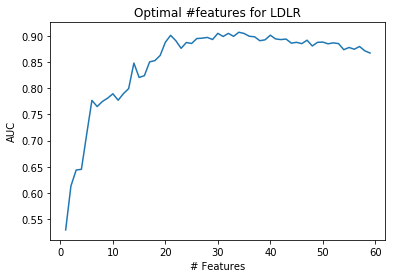

FLI1_HUMAN.H11MO.0.A:fc_samepos	0.380454678321
Regulators of differentiation{5.1.1}:stddev_fc	0.375384813175
MNX1_HUMAN.H11MO.0.D:fc_samepos	0.368412798271
TBX1-related factors{6.5.3}:stddev_fc	0.243823155528
ZIC2_HUMAN.H11DI.0.D:fc_samepos	0.223406281322
COT2_HUMAN.H11MO.1.A:pval_1_best	0.212504457217
FOXB1_HUMAN.H11MO.0.D:fc_samepos	0.199565859977
MEF2D_HUMAN.H11MO.0.A:fc_samepos	0.187309861882
PLAL1_HUMAN.H11MO.0.D:fc_samepos	0.184245828539
ZN667_HUMAN.H11DI.0.C:fc_samepos	0.181603164645
Paired domain only{3.2.2}:median_fc	0.167930173455
CDX2_HUMAN.H11DI.0.A:fc_samepos	0.161911235424
SMAD3_HUMAN.H11MO.0.B:fc_samepos	0.147808182286
TBR1_HUMAN.H11MO.0.D:pval_1_best	0.147759675281
ZBT14_HUMAN.H11MO.0.C:fc_samepos	0.147408099845
phastCons100way	0.146974836942
PPARD_HUMAN.H11MO.0.D:fc_samepos	0.140797026688
IRF1_HUMAN.H11MO.0.A:fc_samepos	0.140263627283
Other factors with up to three adjacent zinc fingers{2.3.2}:stddev_fc	0.136372632114
HD-CUT factors{3.1.9}:median_pval	0.130343672354
EO

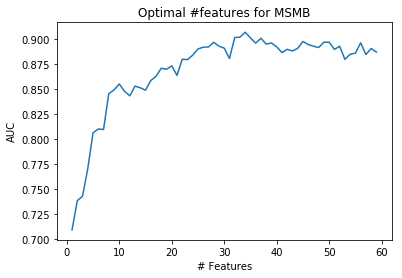

ZN335_HUMAN.H11MO.1.A:pval_1_best	0.59381446708
Factors with multiple dispersed zinc fingers{2.3.4}:stddev_fc	0.424332157243
CENPB_HUMAN.H11MO.0.D:fc_samepos	0.266113974503
FOXD2_HUMAN.H11MO.0.D:pval_1_best	0.252175413189
More than 3 adjacent zinc finger factors{2.3.3}:stddev_fc	0.240737165208
ZN589_HUMAN.H11MO.0.D:fc_samepos	0.20546878723
MYCN_HUMAN.H11MO.0.A:fc_samepos	0.200358491507
STF1_HUMAN.H11MO.0.B:fc_samepos	0.183861627476
MYCN_HUMAN.H11DI.0.A:fc_samepos	0.16101678717
FOXP3_HUMAN.H11MO.0.D:fc_samepos	0.144001740729
RARA_HUMAN.H11MO.1.A:fc_samepos	0.138001565007
HXD10_HUMAN.H11MO.0.D:fc_samepos	0.13464293594
GCR_HUMAN.H11MO.1.A:fc_samepos	0.123832227197
TAF1_HUMAN.H11DI.0.A:fc_samepos	0.117469676421
MYB_HUMAN.H11DI.0.A:fc_samepos	0.114344418282
GLIS1_HUMAN.H11MO.0.D:fc_samepos	0.113727166899
CXXC1_HUMAN.H11MO.0.D:fc_samepos	0.111267007305
ELK4_HUMAN.H11DI.0.A:fc_samepos	0.107542686863
PKNX1_HUMAN.H11MO.0.B:fc_samepos	0.10732658708
COE1_HUMAN.H11MO.0.A:fc_samepos	0.10597433045
D

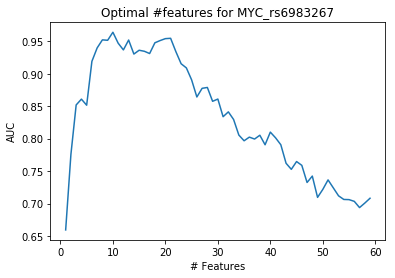

OLIG2_HUMAN.H11MO.0.B:fc_samepos	0.588873738423
CDC5L_HUMAN.H11MO.0.D:fc_samepos	0.543827004265
ZBT18_HUMAN.H11MO.0.C:fc_samepos	0.540586797521
TEF-1-related factors{3.6.1}:stddev_fc	0.50766512705
BATF_HUMAN.H11MO.1.A:pval_1_best	0.480765142012
ZBT7A_HUMAN.H11DI.0.A:fc_samepos	0.476208419539
TCF-7-related factors{4.1.3}:median_fc	0.473881295882
NR4A1_HUMAN.H11MO.0.A:pval_1_best	0.374840393662
ATOH1_HUMAN.H11MO.0.B:fc_samepos	0.356626108289
FOXA2_HUMAN.H11MO.0.A:pval_1_best	0.323155749124
FOXH1_HUMAN.H11DI.0.A:fc_samepos	0.300821716897
OTX2_HUMAN.H11DI.0.A:fc_samepos	0.300707826857
bHLH-ZIP factors{1.2.6}:stddev_pval	0.300045383163
FOXA2_HUMAN.H11DI.0.A:pval_1_best	0.292599814013
TEF_HUMAN.H11MO.0.D:fc_samepos	0.290833451785
TBX5_HUMAN.H11MO.0.D:pval_1_best	0.277468126733
MLXPL_HUMAN.H11MO.0.D:pval_1_best	0.271121159196
PAX7_HUMAN.H11MO.0.D:fc_samepos	0.24186483724
SMAD3_HUMAN.H11DI.0.C:fc_samepos	0.240572954528
ZNF85_HUMAN.H11DI.0.C:fc_samepos	0.227130001411
ZN667_HUMAN.H11MO.0.C:fc_sa

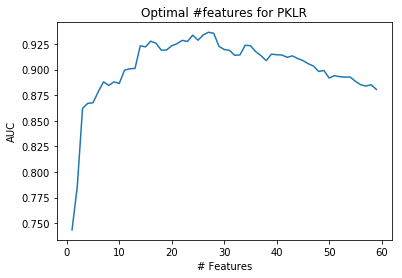

ZN467_HUMAN.H11DI.0.C:pval_1_best	0.461554909125
GABPA_HUMAN.H11MO.0.A:pval_1_best	0.402273461223
HXA9_HUMAN.H11DI.0.B:fc_samepos	0.38715744717
HXB6_HUMAN.H11MO.0.D:pval_1_best	0.248506403062
ZN341_HUMAN.H11MO.1.C:pval_1_best	0.227170789614
NR2F6_HUMAN.H11MO.0.D:fc_samepos	0.202269480331
KLF9_HUMAN.H11DI.0.C:fc_samepos	0.19501121738
HXC8_HUMAN.H11MO.0.D:pval_1_best	0.194591191714
RXRA_HUMAN.H11MO.1.A:fc_samepos	0.165733896894
JUND_HUMAN.H11MO.0.A:fc_samepos	0.16104191984
TBX21_HUMAN.H11MO.0.A:fc_samepos	0.156799551798
NFKB2_HUMAN.H11DI.0.B:fc_samepos	0.155494236853
MEIS2_HUMAN.H11MO.0.B:fc_samepos	0.148820065195
NR1H3_HUMAN.H11DI.0.A:fc_samepos	0.147261970909
Heteromeric CCAAT-binding factors{4.2.1}:stddev_fc	0.1382837696
More than 3 adjacent zinc finger factors{2.3.3}:median_fc	0.128080775263
ELF1_HUMAN.H11DI.0.A:fc_samepos	0.127852905192
CLOCK_HUMAN.H11MO.0.C:fc_samepos	0.127551119309
PROX1_HUMAN.H11MO.0.D:fc_samepos	0.121111062705
FOXF2_HUMAN.H11MO.0.D:fc_samepos	0.108666056767
TEAD

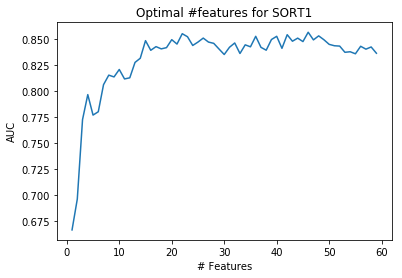

IRF3_HUMAN.H11MO.0.B:pval_1_best	0.395801198669
CREB-related factors{1.1.7}:stddev_pval	0.272078918992
ZBT18_HUMAN.H11MO.0.C:pval_1_best	0.264903884497
TBX1-related factors{6.5.3}:median_fc	0.25782749115
E2F8_HUMAN.H11MO.0.D:fc_samepos	0.23311889905
ZNF41_HUMAN.H11MO.0.C:fc_samepos	0.193810458528
ATF3_HUMAN.H11DI.0.A:fc_samepos	0.180015879683
ZN547_HUMAN.H11MO.0.C:fc_samepos	0.17911256908
ATF3_HUMAN.H11MO.0.A:fc_samepos	0.177354034269
HMBX1_HUMAN.H11MO.0.D:pval_1_best	0.157150810235
Other factors with up to three adjacent zinc fingers{2.3.2}:median_fc	0.149134453502
Paired domain only{3.2.2}:median_fc	0.146112243528
PO3F2_HUMAN.H11DI.0.A:fc_samepos	0.138859920786
ZN263_HUMAN.H11MO.1.A:pval_1_best	0.130941636511
SOX5_HUMAN.H11MO.0.C:fc_samepos	0.125590113574
ITF2_HUMAN.H11DI.0.C:fc_samepos	0.124054466956
Factors with multiple dispersed zinc fingers{2.3.4}:stddev_fc	0.119390457636
E2F1_HUMAN.H11DI.0.A:fc_samepos	0.11663048435
ARID-related factors{3.7.1}:stddev_fc	0.109221928404
ERR1_HUMA

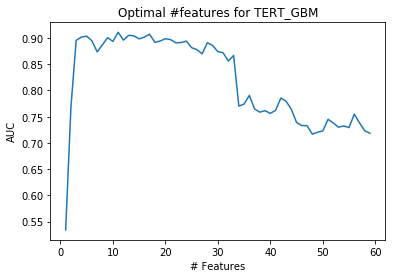

P53_HUMAN.H11MO.0.A:fc_samepos	0.70596087072
Responders to external signals (SRF/RLM1){5.1.2}:stddev_pval	0.647410769947
MYOG_HUMAN.H11MO.0.B:pval_1_best	0.453492970206
TFAP4_HUMAN.H11MO.0.A:pval_1_best	0.392176063498
DLX1_HUMAN.H11MO.0.D:fc_samepos	0.353601991665
CEBPZ_HUMAN.H11MO.0.D:pval_1_best	0.336575428024
ZN554_HUMAN.H11DI.0.C:fc_samepos	0.279119227547
ZN563_HUMAN.H11MO.1.C:fc_samepos	0.234136376996
ZN586_HUMAN.H11DI.0.C:fc_samepos	0.231973502319
RUNX2_HUMAN.H11DI.0.A:pval_1_best	0.227272991557
GCR_HUMAN.H11MO.1.A:fc_samepos	0.21757086087
ZN418_HUMAN.H11MO.1.D:fc_samepos	0.214613478631
ZN394_HUMAN.H11DI.0.C:fc_samepos	0.213075256674
ZN134_HUMAN.H11DI.0.C:fc_samepos	0.209165312815
EGR4_HUMAN.H11MO.0.D:fc_samepos	0.194960047025
ELF2_HUMAN.H11MO.0.C:fc_samepos	0.176098995144
NR5A2_HUMAN.H11DI.0.B:fc_samepos	0.167975879041
PRGR_HUMAN.H11DI.0.A:fc_samepos	0.167257841211
STAT6_HUMAN.H11MO.0.B:pval_1_best	0.165091006318
ZN528_HUMAN.H11DI.0.C:fc_samepos	0.150007315446
SIX1_HUMAN.H11MO.0

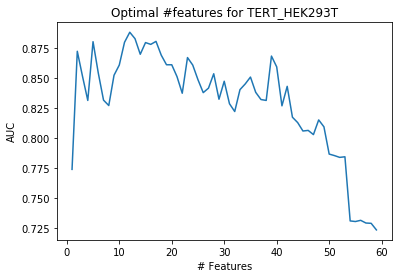

Responders to external signals (SRF/RLM1){5.1.2}:stddev_pval	0.899339299183
CUX1_HUMAN.H11MO.0.C:fc_samepos	0.717023196863
HSF2_HUMAN.H11MO.0.A:fc_samepos	0.396887460025
HSFY1_HUMAN.H11MO.0.D:fc_samepos	0.372938948683
SPDEF_HUMAN.H11MO.0.D:fc_samepos	0.343036305858
GABPA_HUMAN.H11MO.0.A:fc_samepos	0.3371717548
CP2-related factors{6.7.2}:stddev_pval	0.309548001271
STAT6_HUMAN.H11MO.0.B:pval_1_best	0.300863509066
P73_HUMAN.H11MO.1.A:fc_samepos	0.288310028845
MYBA_HUMAN.H11MO.0.D:fc_samepos	0.273609772557
ELK1_HUMAN.H11DI.0.B:fc_samepos	0.271944378037
NRF1_HUMAN.H11MO.0.A:fc_samepos	0.27054389054
HES7_HUMAN.H11MO.0.D:fc_samepos	0.270124984207
PTF1A_HUMAN.H11MO.0.B:pval_1_best	0.267913177377
USF1_HUMAN.H11DI.0.A:fc_samepos	0.255805048859
MYBA_HUMAN.H11DI.0.D:fc_samepos	0.242851496208
ELK1_HUMAN.H11MO.0.B:fc_samepos	0.235032176366
FOS_HUMAN.H11MO.0.A:fc_samepos	0.230741588864
UBIP1_HUMAN.H11MO.0.D:pval_1_best	0.214282927103
ELK4_HUMAN.H11MO.0.A:fc_samepos	0.213689842727
KLF4_HUMAN.H11MO.0.A

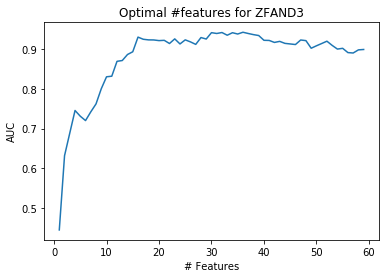

ZN331_HUMAN.H11DI.0.C:fc_samepos	0.494601695798
GFI1_HUMAN.H11MO.0.C:pval_1_best	0.366979219019
ZN467_HUMAN.H11MO.0.C:fc_samepos	0.305203078547
P53_HUMAN.H11MO.1.A:fc_samepos	0.300570096704
STAT4_HUMAN.H11DI.0.A:fc_samepos	0.222345172428
PRD14_HUMAN.H11MO.0.A:fc_samepos	0.219201339176
RFX-related factors{3.3.3}:stddev_fc	0.213144998765
Responders to external signals (SRF/RLM1){5.1.2}:stddev_fc	0.206400873722
LMX1A_HUMAN.H11MO.0.D:pval_1_best	0.203417389072
MAFA_HUMAN.H11MO.0.D:pval_1_best	0.196262906305
PROX1_HUMAN.H11MO.0.D:fc_samepos	0.191713462467
CREB5_HUMAN.H11MO.0.D:pval_1_best	0.177966625546
THA_HUMAN.H11MO.0.C:fc_samepos	0.169307338307
FOXA1_HUMAN.H11MO.0.A:fc_samepos	0.16868576745
RORA_HUMAN.H11MO.0.C:fc_samepos	0.157060422585
HXC13_HUMAN.H11MO.0.D:pval_1_best	0.149808170972
KAISO_HUMAN.H11MO.1.A:fc_samepos	0.144598929561
TBP_HUMAN.H11DI.0.A:fc_samepos	0.139661038294
MAZ_HUMAN.H11MO.0.A:fc_samepos	0.133264650358
ESR1_HUMAN.H11MO.1.A:fc_samepos	0.129138092627
SPI1_HUMAN.H11DI.0

In [154]:
feature_importances_sorted_by_construction = {}
plots_by_construction = {}
for construction in CONSTRUCTONS:
    data = FULL_DATA[FULL_DATA.construction==construction]
    del data['mz46_pre']
    del data['mz100_pre']
    feature_names = split_features_and_target(data)[0].keys()

    feature_importances = np.zeros( (len(feature_names),) )
    for i in range(20):
        classifier = sklearn.svm.LinearSVC() #xgb.XGBClassifier(max_depth=3, n_estimators=100)
        X, y = split_features_and_target( data.sample(frac=0.8) )
        y = 0 + (y > 0.1) 
        classifier.fit(X, y)
        feature_importances += classifier.feature_importances_

    xs = []
    aucs = []
    features_w_importances_sorted = list(sorted(zip(feature_names,feature_importances), key=lambda kv: -kv[1]))
    feature_importances_sorted_by_construction[construction] = features_w_importances_sorted
    features_sorted = list(map(lambda kv: kv[0], features_w_importances_sorted))
    for num_features in range(1,60):
        best_features = features_sorted[0:num_features]
        xs.append(num_features)
        aucs.append(test_by_block(filter_features(data, lambda f: f in best_features))['test'])
        print(num_features,end=' ')
    plots_by_construction[construction] = (xs,aucs)
    plt.figure()
    plt.plot(xs, aucs)
    plt.xlabel('# Features')
    plt.ylabel('AUC')
    plt.title('Optimal #features for ' + construction)
    plt.show()
    print('\n'.join(map(lambda rec: rec[0] + '\t'+ str(rec[1]),features_w_importances_sorted[0:25])))

In [12]:
def test_feature_subset_pairwise(data, feature_types, construction_to_test, constructions_to_train=CONSTRUCTONS):
    auc_results = {}
    data = filter_features_by_type(data, feature_types)
    for construction_to_train in constructions_to_train:
        if construction_to_train != construction_to_test:
            auc_results[construction_to_train] = train_and_test_feature_subset(test_data=data[data.construction == construction_to_test],
                                                                               train_data=data[data.construction == construction_to_train])
    
    return list(sorted(auc_results.items(), key=lambda (k,v): -v))

for construction_to_test in CONSTRUCTONS:
    constructions_ordered = list(map(lambda x: x[0], test_feature_subset_pairwise(FULL_DATA, 'all', construction_to_test)))
    data = filter_features_by_type(FULL_DATA, 'all')
    max_auc = 0
    best_construction_combination = []
    for i in range(1,len(constructions_ordered)+1):
        auc_ = train_and_test_feature_subset(test_data=data[data.construction==construction_to_test],
                                            train_data=select_data_by(data, 'construction', constructions_ordered[0:i]).sample(frac=0.5))
        # print(constructions_ordered[0:i], auc_)
        if auc_ > max_auc:
            max_auc = auc_
            best_construction_combination = constructions_ordered[0:i]
    print(construction_to_test, max_auc, best_construction_combination, sep='\t')
    

F9	0.733009708738	['HNF4A_P2', 'LDLR', 'IRF6', 'IRF4', 'MSMB', 'HBG1', 'GP1BB', 'TERT_HEK293T', 'HBB']
GP1BB	0.805749973081	['IRF4', 'MSMB', 'TERT_GBM', 'LDLR', 'SORT1', 'ZFAND3', 'HNF4A_P2', 'HBB', 'IRF6', 'F9', 'MYC_rs6983267', 'TERT_HEK293T']
HBB	0.694444444444	['TERT_GBM', 'MYC_rs6983267', 'SORT1', 'ZFAND3', 'HBG1', 'LDLR', 'GP1BB']
HBG1	0.80128992629	['MYC_rs6983267', 'IRF6', 'MSMB', 'TERT_GBM', 'SORT1', 'HBB', 'F9', 'LDLR']
HNF4A_P2	0.809356725146	['ZFAND3', 'LDLR', 'IRF6', 'GP1BB', 'TERT_HEK293T', 'HBB', 'IRF4', 'MSMB', 'F9', 'HBG1', 'TERT_GBM', 'MYC_rs6983267']
IRF4	0.75307722029	['GP1BB', 'TERT_GBM', 'SORT1', 'IRF6', 'LDLR', 'TERT_HEK293T', 'F9', 'MSMB']
IRF6	0.732622491145	['HBG1', 'HBB', 'PKLR', 'MSMB', 'ZFAND3', 'IRF4']
LDLR	0.830197132616	['IRF4', 'ZFAND3', 'IRF6', 'SORT1', 'MSMB', 'TERT_GBM']
MSMB	0.782142262202	['LDLR', 'GP1BB', 'ZFAND3', 'HNF4A_P2', 'TERT_GBM', 'F9', 'MYC_rs6983267', 'TERT_HEK293T', 'IRF6']
MYC_rs6983267	0.768451905143	['HBB', 'ZFAND3', 'SORT1', 'MSMB',

In [16]:
construction_sets = [('F9', ['HNF4A_P2', 'LDLR', 'IRF6', 'IRF4']),
('GP1BB', ['IRF4', 'MSMB']),
('HBB', ['TERT_GBM', 'MYC_rs6983267']),
('HBG1', ['MYC_rs6983267', 'IRF6', 'MSMB', 'TERT_GBM', 'SORT1', 'HBB']),
('HNF4A_P2', ['ZFAND3', 'LDLR', 'IRF6']),
('IRF4', ['GP1BB', 'TERT_GBM', 'SORT1', 'IRF6', 'LDLR', 'TERT_HEK293T', 'F9', 'MSMB', 'HNF4A_P2', 'HBB']),
('IRF6', ['HBG1', 'HBB', 'PKLR', 'MSMB', 'ZFAND3', 'IRF4', 'LDLR', 'SORT1', 'TERT_GBM']),
('LDLR', ['IRF4', 'ZFAND3', 'IRF6', 'SORT1', 'MSMB', 'TERT_GBM', 'HBG1', 'GP1BB', 'TERT_HEK293T', 'HNF4A_P2', 'HBB', 'PKLR']),
('MSMB', ['LDLR', 'GP1BB', 'ZFAND3', 'HNF4A_P2', 'TERT_GBM', 'F9', 'MYC_rs6983267', 'TERT_HEK293T', 'IRF6', 'IRF4', 'HBB', 'HBG1']),
('MYC_rs6983267', ['HBB']),
('PKLR', ['SORT1', 'LDLR', 'ZFAND3', 'IRF6', 'HBB', 'HBG1', 'MSMB', 'IRF4', 'TERT_HEK293T', 'TERT_GBM', 'GP1BB', 'MYC_rs6983267', 'HNF4A_P2']),
('SORT1', ['PKLR', 'MYC_rs6983267', 'ZFAND3', 'MSMB']),
('TERT_GBM', ['LDLR', 'TERT_HEK293T', 'GP1BB', 'IRF4', 'SORT1', 'MSMB', 'IRF6', 'HBG1', 'F9', 'HNF4A_P2', 'HBB', 'MYC_rs6983267', 'ZFAND3']),
('TERT_HEK293T', ['TERT_GBM', 'MSMB', 'LDLR', 'SORT1', 'IRF4', 'IRF6', 'PKLR', 'GP1BB']),
('ZFAND3', ['LDLR', 'SORT1', 'TERT_GBM', 'PKLR', 'IRF6', 'TERT_HEK293T', 'HBG1', 'HNF4A_P2', 'MSMB', 'HBB', 'IRF4', 'GP1BB'])]
for construction_to_test, constructions_to_train in construction_sets:
    data = filter_features_by_type(FULL_DATA, 'all')    
    auc_ = train_and_test_feature_subset(test_data=data[data.construction==construction_to_test],
                                        train_data=select_data_by(data, 'construction', constructions_to_train).sample(frac=0.9))
    print(construction_to_test, auc_, sep='\t')
    

F9	0.68394590846
GP1BB	0.808549585442
HBB	0.708994708995
HBG1	0.683814496314
HNF4A_P2	0.753996101365
IRF4	0.747115968427
IRF6	0.73856257379
LDLR	0.818623058542
MSMB	0.784341162752
MYC_rs6983267	0.747934985345
PKLR	0.810666110416
SORT1	0.753658008658
TERT_GBM	0.892602495544
TERT_HEK293T	0.890554722639
ZFAND3	0.756073769242


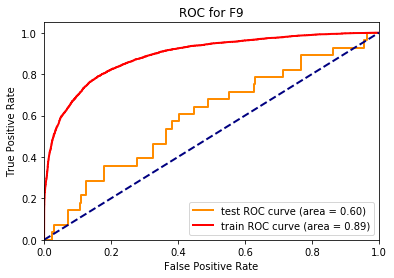

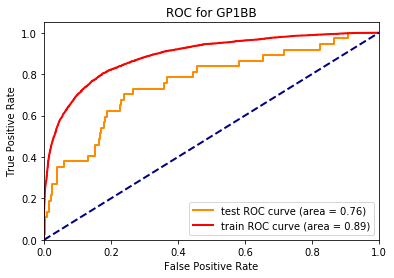

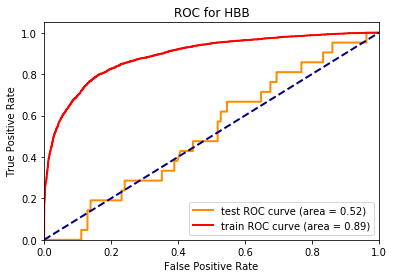

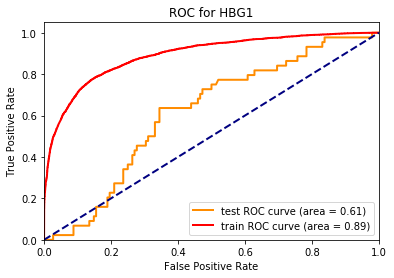

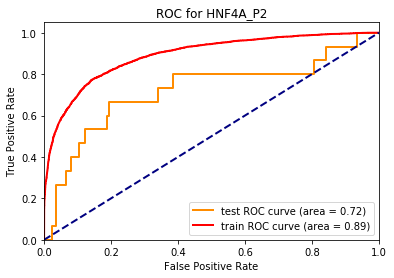

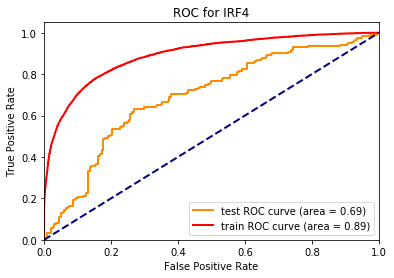

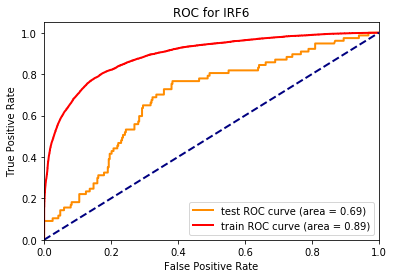

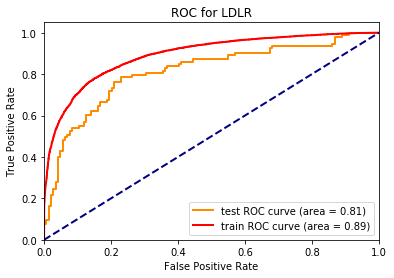

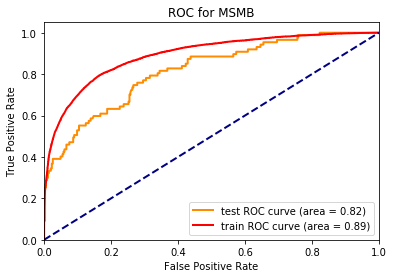

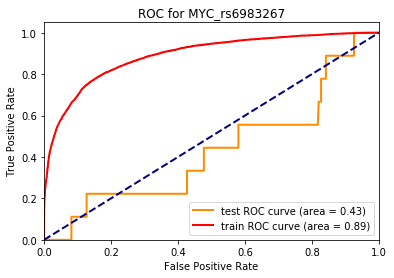

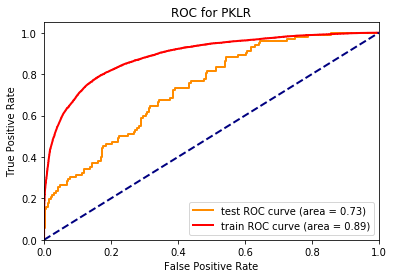

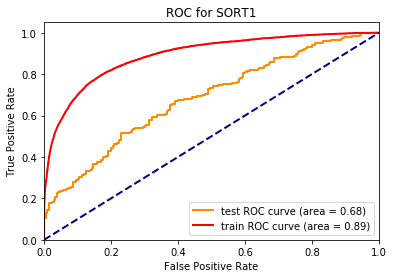

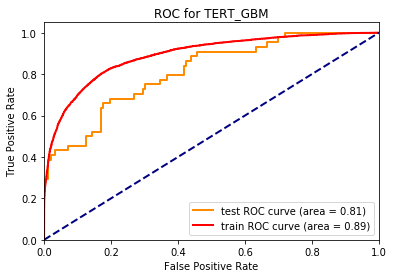

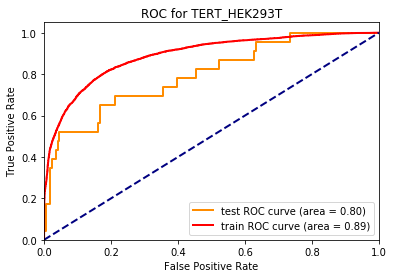

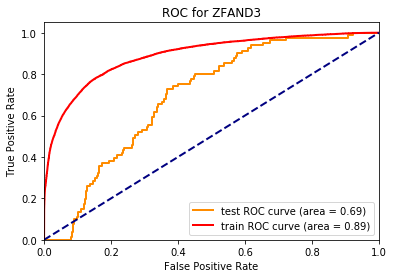

Features: all 

construction	test	train
-----------------------------

F9	0.5981	0.8916
GP1BB	0.7587	0.8908
HBB	0.5179	0.8911
HBG1	0.6148	0.8913
HNF4A_P2	0.7205	0.8907
IRF4	0.6923	0.891
IRF6	0.6887	0.8925
LDLR	0.8129	0.8924
MSMB	0.8157	0.8913
MYC_rs6983267	0.4326	0.8903
PKLR	0.7341	0.8907
SORT1	0.6829	0.8911
TERT_GBM	0.8127	0.8916
TERT_HEK293T	0.7974	0.8903
ZFAND3	0.6922	0.8908
AUC ROC values in constant order for test datasets:
0.5981
0.7587
0.5179
0.6148
0.7205
0.6923
0.6887
0.8129
0.8157
0.4326
0.7341
0.6829
0.8127
0.7974
0.6922


In [115]:
test_feature_subset_by_block(FULL_DATA, 'all',#['pval_1_best', 'fc_samepos'],
                    classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=100, max_depth=3), useRegression=True)

In [ ]:
test_feature_subset(FULL_DATA, ['pval_1_best', 'fc_samepos', 'gerp_rs', 'phyloP100way', 'phyloP46way', 'phastCons46way', 'phastCons100way'])

In [ ]:
test_feature_subset_by_block(FULL_DATA, ['pval_1_best', 'fc_samepos', 'gerp_rs', 'phyloP100way', 'phyloP46way', 'phastCons46way', 'phastCons100way'])

In [ ]:
test_feature_subset(FULL_DATA, ['pval_1_best', 'fc_samepos'], classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, scale_pos_weight=0.5))

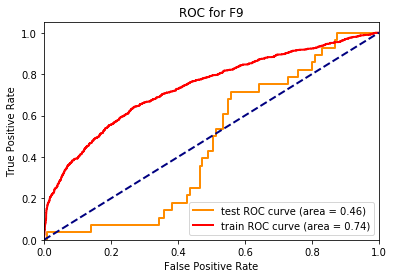

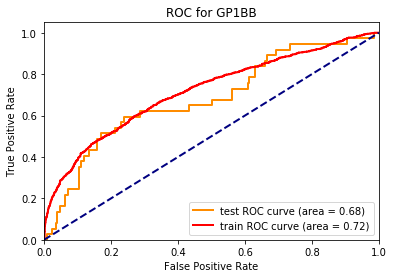

KeyboardInterrupt: 

In [104]:
test_feature_subset(FULL_DATA, 'all',
        classifierBuilder=lambda: sklearn.svm.SVC(kernel='linear', C=1, probability=True, cache_size=1000))

In [ ]:
test_feature_subset(FULL_DATA, 'all'
        classifierBuilder=lambda: sklearn.svm.SVC(kernel='poly', probability=True))

In [ ]:
feature_ranks = {}
classifiers = {}
for construction in CONSTRUCTONS:
    X_train, y_train = split_features_and_target(FULL_DATA[FULL_DATA['construction'] != construction])
    clf = catboost.CatBoostClassifier().load_model('models/catboost/' + construction + '.cbm')
    feature_importances = clf.get_feature_importance(X_train, y_train)
#     print('===========================\n'+construction)
#     for feature, importance in itertools.islice(sorted(zip(data.keys(), feature_importances), key=lambda pair: -pair[1]), 0, 10):
#         print(feature, round(importance, 3), sep="\t")
    for rank, (feature, importance) in enumerate(sorted(zip(X_train.keys(), feature_importances), key=lambda pair: -pair[1])):
        if feature not in feature_ranks:
            feature_ranks[feature] = []
        feature_ranks[feature].append(rank)

features_to_add = []
for feature, ranks in itertools.islice(sorted(feature_ranks.items(), key= lambda pair: np.mean(pair[1])), 50):
    # print(feature, np.median(ranks), np.mean(ranks), np.std(ranks))
    features_to_add.append(feature)

FULL_DATA = FULL_DATA.filter(items = ['SNV', 'construction', 'value', 'confidence'] + features_to_add)

In [ ]:
for n_estimators in [75,100,150,200,250]:
    print(n_estimators, '-->', end=' ')
    test_feature_subset(FULL_DATA, ['pval_1_best', 'fc_samepos'], constructions_to_test=['GP1BB'], 
        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=n_estimators, max_depth=3, reg_alpha=0.1,
                                                   reg_lambda=1.0, n_jobs=-1))


In [ ]:
        0.0   0.1  0.15 0.2
75  --> 0.61
100 --> 0.64  0.65 0.66 0.59
150 --> 0.67
200 --> 0.69  0.68 0.69 0.64
250 --> 0.68
300 --> 0.68
500 --> 0.68



In [ ]:
test_feature_subset(FULL_DATA, ['pval_1_best', 'fc_samepos'],
        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=250, max_depth=3, reg_alpha=0.1, n_jobs=-1))

In [ ]:
test_feature_subset(FULL_DATA, ['pval_1_best', 'fc_samepos'],
        classifierBuilder=lambda:xgb.XGBRegressor(n_estimators=100, max_depth=3, reg_alpha=0.0, n_jobs=-1))

In [ ]:

#     regressor = xgb.XGBRegressor(n_jobs=-1, n_estimators=100, learning_rate=0.1).fit(X_train, y_train)
#     X_train = X_train.as_matrix()[:, regressor.feature_importances_ > 0.003]
#     X_test = X_test.as_matrix()[:, regressor.feature_importances_ > 0.003]
    
#     feature_selector_1 = sklearn.feature_selection.VarianceThreshold()
#     feature_selector_1.fit(X_train, y_train)
#     X_train = feature_selector_1.transform(X_train)
#     X_test = feature_selector_1.transform(X_test)
    
#     feature_selector_2 = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif, k=10)
#     feature_selector_2.fit(X_train, y_train)
#     X_train = feature_selector_2.transform(X_train)
#     X_test = feature_selector_2.transform(X_test)

#     lsvc = LinearSVC(C=1, penalty="l1", dual=False, verbose=1)
#     lsvc.fit(X_train, y_train)    
#     model_select = sklearn.feature_selection.SelectFromModel(lsvc, prefit=True)
#     X_train = model_select.transform(X_train)
#     X_test = model_select.transform(X_test)

    #X_train = pca.transform(X_train)
    #X_test = pca.transform(X_test)    
    
    #X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, answers, train_size=0.5,
    #                                                    random_state=rand_state)
    
#     classifier = svm.LinearSVC(class_weight='balanced', random_state=13,C=1)
#     classifier.fit(X_train, y_train)
#     y_score_test = classifier.decision_function(X_test)
#     y_score_train = classifier.decision_function(X_train)
    
    #classifier = catboost.CatBoostClassifier(random_seed=17, logging_level='Verbose')
    

In [ ]:
classifiers = {}
auc_results = {}
for construction in CONSTRUCTONS:
    X_train, y_train = split_features_and_target(FULL_DATA[FULL_DATA['construction'] != construction])
    X_test, y_test = split_features_and_target(FULL_DATA[FULL_DATA['construction'] == construction])
    
    #regressor = xgb.XGBRegressor(n_jobs=-1, n_estimators=100, learning_rate=0.1).fit(X_train, y_train)
    #X_train = X_train.as_matrix()[:, regressor.feature_importances_ > 0.003]
    #X_test = X_test.as_matrix()[:, regressor.feature_importances_ > 0.003]
    
    classifier = xgb.XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
    classifier.fit(X_train, y_train)
    
    classifiers[construction] = classifier
    y_score_test = classifier.predict(X_test)
    y_score_train = classifier.predict(X_train)
    
    y_test = 0 + (y_test > 0.1)
    y_train = 0 + (y_train > 0.1)
        
    auc_results[construction] = get_rocs(
        [ (y_test, y_score_test, 'test'), 
          (y_train, y_score_train, 'train')],
        label='ROC for ' + construction,
        plot = True,
        filename = 'roc_curves/catboost_fc_expr_only/' + construction + '.png')


In [ ]:
for feature, importance in itertools.islice(sorted(zip(data.keys(), classifiers['F9']._feature_importance), key=lambda pair: -pair[1]), 0, 30):
    print(feature, importance, sep="\t")
# for construction, classifier in classifiers.items():
#     classifier.save_model("models/catboost/"+construction+".cbm")


In [ ]:
pca = sklearn.decomposition.PCA(n_components=10)
FULL_DATA_features_only, _FULL_DATA_answers = split_features_and_target(FULL_DATA)
pca.fit(FULL_DATA_features_only)

In [ ]:
data, answers = split_features_and_target(FULL_DATA)
data = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif, k=50).fit_transform(data, answers)
# clf = sklearn.linear_model.LassoCV()
# sfm = sklearn.feature_selection.SelectFromModel(clf, threshold=0.25)
# sfm.fit(data, answers)
# n_features = sfm.transform(data).shape[1]
# print(n_features)


In [ ]:
auc_results = {}
for construction in CONSTRUCTONS:
    data, answers = split_features_and_target(FULL_DATA[FULL_DATA['construction'] == construction])
    auc_results[construction] = []
    plt.figure()
    for rand_state in range(5):
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, answers, train_size=0.5,
                                                            random_state=rand_state)

        # Learn to predict each class against the other
        classifier = sklearn.multiclass.OneVsRestClassifier(svm.LinearSVC(class_weight='balanced', 
                                                                          random_state=13))
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        # Compute ROC curve and ROC area for each class

        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
        fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_test, y_score)
        roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)

        lw = 2
        plt.plot(fpr, tpr, color=colors[rand_state],
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        auc_results[construction].append(roc_auc)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + construction)
    plt.legend(loc="lower right")
    plt.savefig('roc_curves/' + construction + '.png')
    #plt.show()
    
for construction, aucs in sorted(auc_results.items()):
    print(construction + ": ", round(np.mean(aucs),4), "±", round(np.std(aucs),4))

In [ ]:
clf = sklearn.svm.SVC()
rfecv = sklearn.feature_selection.RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
for construction in CONSTRUCTONS:
#     data = FULL_DATA
#     #data = FULL_DATA[FULL_DATA['construction'] == construction]
#     del data['construction']
#     confidence = data['confidence']
#     answers = 0 + (confidence > 0.1)
#     del data['confidence']
    data, answers  = split_features_and_target(FULL_DATA[FULL_DATA['construction'] == construction])
    
    # model = sklearn.linear_model.LogisticRegression()
    model = sklearn.svm.LinearSVC(C=100, max_iter=1000, random_state=13) #(penalty='l2', C=100, class_weight='balanced', max_iter=10000)
    #cv = sklearn.model_selection.LeaveOneOut()
    cv = sklearn.model_selection.StratifiedKFold(5, shuffle=True) # sklearn.model_selection.StratifiedKFold(10)
    #scores = sklearn.model_selection.cross_val_predict(model, data, answers,cv=cv, method='decision_function')
    scores = sklearn.model_selection.cross_validate(model, data, answers, cv=cv,scoring=['f1', 'roc_auc', 'average_precision'], return_train_score=True)
    #print(scores)
    print('=======================\n'+construction)
    print('AP:')
    print(np.mean(scores['train_average_precision']), np.std(scores['train_average_precision']))
    print(np.mean(scores['test_average_precision']), np.std(scores['test_average_precision']))
    print('F1')
    print(np.mean(scores['train_f1']), np.std(scores['train_f1']))
    print(np.mean(scores['test_f1']), np.std(scores['test_f1']))
    print('ROC-AUC')
    print(np.mean(scores['train_roc_auc']), np.std(scores['train_roc_auc']))
    print(np.mean(scores['test_roc_auc']), np.std(scores['test_roc_auc']))

In [ ]:
classifier = sklearn.svm.LinearSVC()
classifier.fit(data, answers)
for (x,y) in itertools.islice(sorted(zip(data.keys(), classifier.coef_[0]), key=lambda pair: -pair[1]), 0, 10):
    print(x,y, sep="\t")

In [ ]:
plt.figure()
classifier = svm.LinearSVC(class_weight='balanced', random_state=13)
sklearn.model_selection.StratifiedKFold(5, shuffle=True)
y_score = sklearn.model_selection.cross_val_predict(classifier, data, answers,cv=cv, method='decision_function')
fpr, tpr, _ = sklearn.metrics.roc_curve(answers, y_score)
roc_auc = sklearn.metrics.auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(answers, y_score)
roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)

lw = 2
plt.plot(fpr, tpr, color=colors[0],
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import catboost

In [ ]:
#error_rates = []
#error_rates_simul = []
f1s = []
for random_state in np.random.randint(0,10000, size=5):
    features_train, features_test, answers_train, answers_test = sklearn.model_selection.train_test_split(data, answers, test_size=0.3, random_state=random_state)
    # clf = sklearn.svm.LinearSVC(random_state=0, penalty='l1', dual=False)
    clf = LinearSVC(random_state=0)
    clf.fit(features_train, answers_train)
    #error_rate = 1 - clf.score(features_test, answers_test)
    #error_rates.append(error_rate)
    #random_answer = np.random.choice([0,1],len(features_test))
    #random_answer = np.random.choice([1] * sum(answers_test) + [0] * (sum(1-answers_test)), size=len(answers_test))
    #error_rate_simul = sum(abs(answers_test - random_answer)) * 1.0 / len(features_test)
    
    #error_rates_simul.append(error_rate_simul)
    #print(error_rate)
    f1s.append(sklearn.metrics.f1_score(answers_test, clf.predict(features_test), average='binary'))
    print('.',end='')
print()
print(f1s)
print(np.mean(f1s), np.std(f1s))
#print(np.mean(error_rates), np.std(error_rates))
#print(np.mean(error_rates_simul), np.std(error_rates_simul))

In [ ]:
res = defaultdict(int)
for (x,y) in zip(data.keys(), clf.coef_[0]):
    key_type = x.split(':')[-1]
    if abs(y) > 0.15:
        res[key_type] += 1
    #res[key_type] += abs(y)
res

In [ ]:
for (x,y) in zip(data.keys(), clf.coef_[0]):
    motif, key_type = x.split(':')
    
    #if (key_type == 'same_pos' or key_type == 'same_strand') and abs(y) >= 0.15:
    #    print(x, y)
    if motif.startswith('ZN140_HUMAN'):
        print(x,y)

In [ ]:
pca_2 = sklearn.decomposition.PCA(n_components=2)
pca_2.fit(data)
data_2 = pca_2.transform(data)
print(sum(pca_2.explained_variance_ratio_))
print(pca_2.explained_variance_ratio_)
#error_rates = []
#for random_state in [13,17,42,48,93,97,99,121,137,1024]:
#    features_train, features_test, answers_train, answers_test = sklearn.model_selection.train_test_split(data_2, answers, test_size=0.3, random_state=random_state)
#    clf = LinearSVC(random_state=0)
#    clf.fit(features_train, answers_train)
#    error_rate = 1 - clf.score(features_test, answers_test)
#    error_rates.append(error_rate)
#    print(error_rate)
#print(np.mean(error_rates), np.std(error_rates))


In [ ]:
res = defaultdict(int)
for (x,y) in sorted(zip(data.keys(), pca_2.components_[2]), key=lambda pair: -abs(pair[1])):
    key_type = x.split(':')[1]
    if abs(y) > 0.05:
        res[key_type] += 1
        print(x,y, sep='\t')
print(res)

In [ ]:
cv = sklearn.model_selection.LeaveOneOut()
for train,test in cv.split(data):
    model_ = sklearn.linear_model.LogisticRegression()
    model_.fit(data[train], answers[train])
    print(model_.score(data[test], answers[test]))

In [ ]:
data = FULL_DATA[FULL_DATA['construction'] == 'TERT_GBM']

y_train = np.array([])
y_score_train = np.array([])
y_test = np.array([])
y_score_test = np.array([])

for block_num in np.unique(data['block_num']):
    X_train_block, y_train_block = split_features_and_target(data[data['block_num'] != block_num])
    X_test_block, y_test_block = split_features_and_target(data[data['block_num'] == block_num])

    print('.')
    #classifier = catboost.CatBoostClassifier(random_seed=17, logging_level='Silent', depth = 2,iterations=100)
    classifier = xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
    classifier.fit(X_train_block, y_train_block)
    y_score_test_block = classifier.predict_proba(X_test_block)[:,1]
    y_score_train_block = classifier.predict_proba(X_train_block)[:,1]
    
    y_test = np.hstack((y_test, y_test_block))
    y_score_test = np.hstack((y_score_test, y_score_test_block))
    y_train = np.hstack((y_train, y_train_block))
    y_score_train = np.hstack((y_score_train, y_score_train_block))


plot_rocs( [(y_test, y_score_test, 'test'), (y_train, y_score_train, 'train')], label='ROC for ' + construction, filename = None)


In [ ]:
list(sorted(zip(y_score_train,y_train)))

#import lightgbm as lgb
#import catboost as cgb